# EDA, Classification of Residential Energy Appliance

Greenhouse gas emissions have become an increasingly concerning issue across the globe. They result in climate change, which in turn have far-reaching environmental and health consequences. Energy production and consumption is the main contributor to greenhouse gas emissions. Furthermore, empirical study shows that electricity consumption in residential areas contributes to more than 20% of this total energy consumption. 

In this project, I will be dealing with a time-series dataset. I will attempt to forecast the activation period for various appliances, all of which are commonly used in households in residential areas. This task can prove to be crucial because by using various machine learning techniques and correctly forecasting the activation period of appliances, we will have a better foresight of electricity consumption information, which in turn might provide valuable insights to come up with a better energy-saving technology. 

There are 2 main challenges that we need to address, when it comes to the dataset given. The first challenge is how to effectively tackle a time-series dataset. The second challenge is, there are severe class imbalance issues for most of the target variables. 

To tackle the first challenge, we employ a specific way of implementing cross validation, which we refer to as rolling fold cross validation. For the second challenge, we implement resampling to help alleviate the class imbalance issue. The resampling method that we used is undersampling, with additional modification to preserve the sequential structure of the data in a time-series dataset.

The aim is to develop multiple classifiers for each individual target appliance that can detect whether target appliances are being used in each time interval as correctly as possible. This means that I will develop 5 classifiers for 5 appliances. 

`train` datafile contains 417720 instances, each of which has 15 columns, including load, 5 appliance labels (1 indicating using appliances and 0 indicating not using appliances), two time stamps (such as hour of the day and day of the week), and 7 attributes/features. The 5 appliances are air conditioner (ac), electric vehicle charger (ev), oven, cloth washer (wash), and dryer. Note that all the load data are minute-by-minute meter readings in a sequential manner.

`test` datafile contains 105540 instances, each of which has 10 columns, including load, two timestamps, and 7 attributes but no appliance labels.

A description of all the attributes found in the dataset is as follows:

|Attribute  |Description                                                                           |
|-----------|--------------------------------------------------------------------------------------|
|load     |Energy load.|
|dif      | Difference between two sequential load data points.  |
|absdif   |Absolute value of dif. |
|var  |Variance of load over a neighborhood time window of 30 minutes around each load data point. |
|entropy|The Shannon entropy that measures the "forecastability" of a time series data. |
|nonlinear   |The nonlinearity coefficient is used in Terasvirta's nonlinearity test. |
|hurst|The hurst is used as a measure of the long-term memory of a time series.      
 
## Table of Content
1. [Exploratory Data Analysis](#1)
2. [Model Development](#2)
3. [Prediction Task](#3)
4. [Results and Discussion](#4)

In [2]:
#Load libraries
library(psych)
library(ggplot2)
library(reshape2)
library(GGally)
library(tidyverse)
library(dplyr)
library(data.table)
library(randomForest)
library(caret)
library(glmnet)

## 1. Exploratory Data Analysis <a class="anchor" id="1"></a>

In [4]:
#Load training and testing data
train.data<-read.csv('train.csv')
test.data<-read.csv('test.csv')
head(train.data)
head(test.data)

X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
105541,2.245,0,0,0,0,0,0,Sun,0.987,0.987,6.215,3.074549,0.6788858,0.05290291,0.9940715
105542,2.259,0,0,0,0,0,0,Sun,0.014,0.014,6.215,3.172867,0.6674503,0.05482926,0.9941540
105543,2.269,0,0,0,0,0,0,Sun,0.010,0.010,6.215,3.270112,0.6477770,0.05699074,0.9942200
105544,2.268,0,0,0,0,0,0,Sun,-0.001,0.001,6.215,3.303763,0.6292270,0.05760593,0.9941497
105545,2.270,0,0,0,0,0,0,Sun,0.002,0.002,6.215,3.302744,0.6212951,0.08263997,0.9940406
105546,2.259,0,0,0,0,0,0,Sun,-0.011,0.011,6.215,3.298258,0.6269564,0.08978753,0.9939864


X,load,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
1,1.869,0,Mon,0.000,0.000,0,0,0,0,0
2,1.673,0,Mon,-0.196,0.196,0,0,0,0,0
3,1.660,0,Mon,-0.013,0.013,0,0,0,0,0
4,1.772,0,Mon,0.112,0.112,0,0,0,0,0
5,1.679,0,Mon,-0.093,0.093,0,0,0,0,0
6,1.775,0,Mon,0.096,0.096,0,0,0,0,0


In [5]:
#Convert to target variables to factor
train.data[,'ac']<-factor(train.data[,'ac'])
train.data[,'ev']<-factor(train.data[,'ev'])
train.data[,'oven']<-factor(train.data[,'oven'])
train.data[,'wash']<-factor(train.data[,'wash'])
train.data[,'dryer']<-factor(train.data[,'dryer'])
str(train.data)

'data.frame':	417720 obs. of  16 variables:
 $ X        : int  105541 105542 105543 105544 105545 105546 105547 105548 105549 105550 ...
 $ load     : num  2.25 2.26 2.27 2.27 2.27 ...
 $ ac       : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ ev       : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ oven     : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ wash     : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ dryer    : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ hourofday: int  0 0 0 0 0 0 0 0 0 0 ...
 $ dayofweek: Factor w/ 7 levels "Fri","Mon","Sat",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ dif      : num  0.987 0.014 0.01 -0.001 0.002 ...
 $ absdif   : num  0.987 0.014 0.01 0.001 0.002 ...
 $ max      : num  6.21 6.21 6.21 6.21 6.21 ...
 $ var      : num  3.07 3.17 3.27 3.3 3.3 ...
 $ entropy  : num  0.679 0.667 0.648 0.629 0.621 ...
 $ nonlinear: num  0.0529 0.0548 0.057 0.0576 0.0826 ...
 $ hurst    : num  0.994 0.994 0.994 0.994 0.994 ...


In [6]:
summary(train.data)

       X               load        ac         ev         oven       wash      
 Min.   :105541   Min.   : 0.298   0:316521   0:415385   0:411764   0:409767  
 1st Qu.:209971   1st Qu.: 0.807   1:101199   1:  2335   1:  5956   1:  7953  
 Median :314401   Median : 1.279                                              
 Mean   :314401   Mean   : 2.185                                              
 3rd Qu.:418830   3rd Qu.: 3.358                                              
 Max.   :523260   Max.   :11.794                                              
                                                                              
 dryer        hourofday     dayofweek        dif                absdif      
 0:404144   Min.   : 0.00   Fri:58260   Min.   :-7.970000   Min.   :0.0000  
 1: 13576   1st Qu.: 5.00   Mon:61440   1st Qu.:-0.011000   1st Qu.:0.0020  
            Median :11.00   Sat:58080   Median :-0.001000   Median :0.0100  
            Mean   :11.48   Sun:59940   Mean   :-0.000001   

- `load` seems to be a bit right-skwewed. This makes sense as there cannot be negative value of load. On the other hand, for very rare occasions where multiple appliances are activated, the value of load will be very high, but this is not the common case. 

- `entropy` has IQR from 0.64 to 0.74. `entropy` measures the “forecastability” of a time series, where low values indicate a high signal-to-noise ratio, and large values occur when a series is difficult to forecast. It seems like what we have here mostly fall into the medium range.

- There is an extremely **severe class imbalance** for some target variables, especially `ev` , `oven` , `wash` and `dryer` 

In [7]:
describe(train.data)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X,1,417720,3.144005e+05,1.205855e+05,3.144005e+05,3.144005e+05,1.548279e+05,105541.000,5.232600e+05,4.177190e+05,-1.716869e-17,-1.20000862,1.865746e+02
load,2,417720,2.184664e+00,1.890565e+00,1.279000e+00,1.918025e+00,8.421168e-01,0.298,1.179400e+01,1.149600e+01,1.134783e+00,-0.07882485,2.925155e-03
ac*,3,417720,1.242265e+00,4.284544e-01,1.000000e+00,1.177831e+00,0.000000e+00,1.000,2.000000e+00,1.000000e+00,1.203088e+00,-0.55258008,6.629213e-04
ev*,4,417720,1.005590e+00,7.455626e-02,1.000000e+00,1.000000e+00,0.000000e+00,1.000,2.000000e+00,1.000000e+00,1.326271e+01,173.89984926,1.153563e-04
oven*,5,417720,1.014258e+00,1.185542e-01,1.000000e+00,1.000000e+00,0.000000e+00,1.000,2.000000e+00,1.000000e+00,8.194407e+00,65.14845664,1.834316e-04
wash*,6,417720,1.019039e+00,1.366625e-01,1.000000e+00,1.000000e+00,0.000000e+00,1.000,2.000000e+00,1.000000e+00,7.038652e+00,47.54274261,2.114495e-04
dryer*,7,417720,1.032500e+00,1.773247e-01,1.000000e+00,1.000000e+00,0.000000e+00,1.000,2.000000e+00,1.000000e+00,5.272798e+00,25.80245821,2.743637e-04
hourofday,8,417720,1.148449e+01,6.920358e+00,1.100000e+01,1.148133e+01,8.895600e+00,0.000,2.300000e+01,2.300000e+01,3.070053e-03,-1.20380632,1.070745e-02
dayofweek*,9,417720,4.013646e+00,2.001499e+00,4.000000e+00,4.017057e+00,2.965200e+00,1.000,7.000000e+00,6.000000e+00,-4.563216e-03,-1.25694088,3.096798e-03
dif,10,417720,-7.038207e-07,5.309284e-01,-1.000000e-03,-2.249922e-03,1.482600e-02,-7.970,7.619000e+00,1.558900e+01,1.270821e+00,26.83443496,8.214731e-04


There are no missing values. Next, we explore the boxplots to examine their distribution

Warning message in melt(as.data.frame(train.data[-c(1, 3, 4, 5, 6, 7, 9)])):
"The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(as.data.frame(train.data[-c(1, 3, 4, 5, 6, 7, 9)])). In the next version, this warning will become an error."No id variables; using all as measure variables


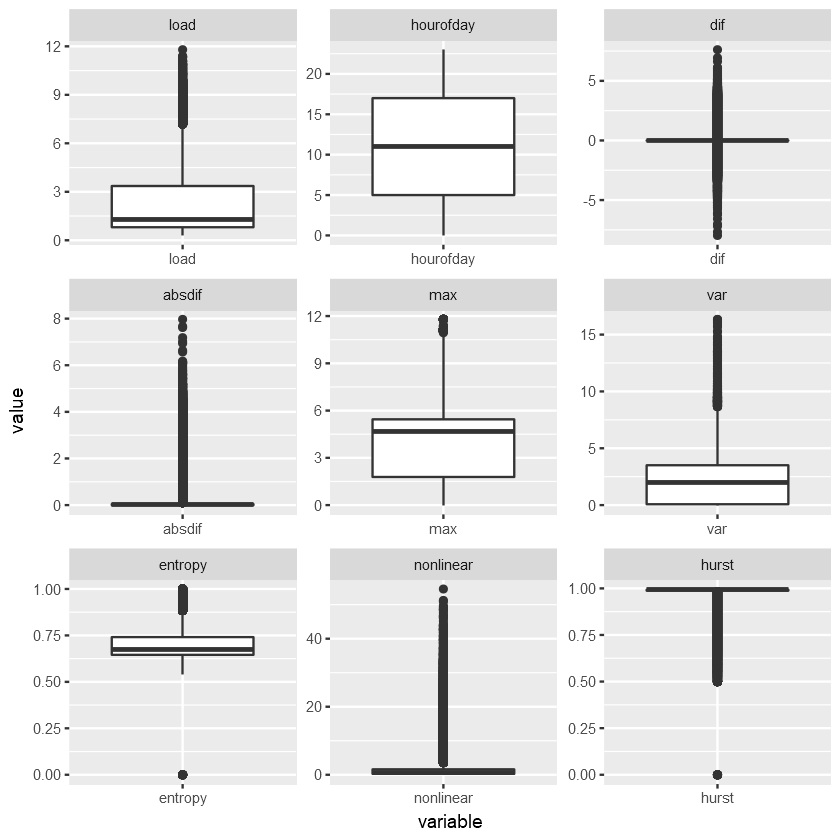

In [8]:
train.box<-melt(as.data.frame(train.data[-c(1,3,4,5,6,7,9)]))
ggplot(train.box,aes(x=variable,y=value))+
    facet_wrap(~variable,scales='free')+
    geom_boxplot()

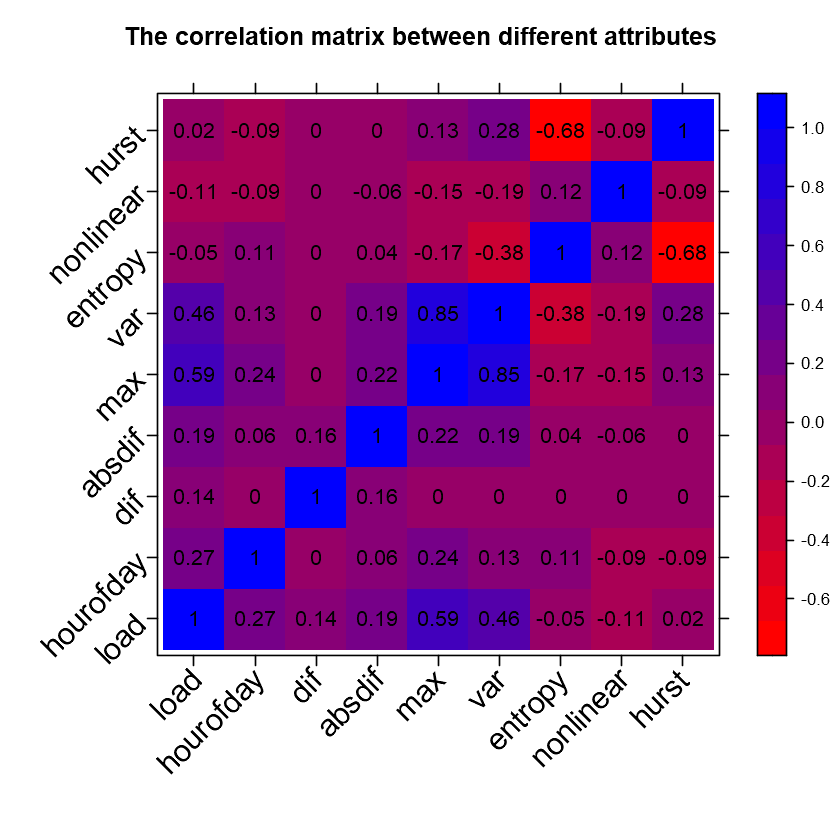

In [9]:
options(repr.plot.width=7, repr.plot.height=7)

# function  of the text of the correlation plot
paneltext <-function(x, y, z, ...) {
    panel.levelplot(x,y,z,...)
    panel.text(x,y,round(z, 2))
}
#Define the color scheme
cols = colorRampPalette(c("red","blue"))
#Plot the correlation matrix.
levelplot(cor(train.data[-c(1,3,4,5,6,7,9)]), col.regions = cols(100), main = "The correlation matrix between different attributes", 
          xlab = NULL, ylab = NULL, 
scales = list(x = list(rot = 45,cex=1.5),y = list(rot = 45,cex=1.5)),panel = paneltext)

- There is a strong positive linear correlation between `var` and `max`

- There is a weak negative linear correlation between `hurst` and `entropy`. As `hurst` increases (greater long-term memory), `entropy` decreases(low value of entropy indicates a high signal-to-noise ratio ->easier to forecast). This makes because increase in `hurst` means a greater long-term memory of a time series, which is consistent with a decrease in `entropy`, which means a higher signal-to-noise ratio, hence makes it easier to forecast.

These correlation will be taken into account when we build randomForest classifier, as randomForest builds trees that have rule-like pattern, hence they implicitly consider variable interaction as well.

In [10]:
train.data[5356:5360,]  #row 5358
train.data[139459:139463,]  #row 139461

,X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
5356,110896,5.319,1,0,0,0,0,17,Wed,0.583,0.583,9.354,9.079162,0.6647435,0.10206690,0.9912188
5357,110897,5.342,1,0,0,0,0,17,Wed,0.023,0.023,9.354,9.207715,0.6651521,0.11780220,0.9908669
5358,110898,1.755,0,0,0,0,0,2,Fri,-3.587,3.587,9.354,9.370639,0.6642243,0.08193567,0.9909383
5359,110899,5.315,1,0,0,0,0,17,Wed,3.560,3.560,9.354,9.531306,0.6619385,0.07256142,0.9910337
5360,110900,5.336,1,0,0,0,0,17,Wed,0.021,0.021,9.354,9.692591,0.6593139,0.06454659,0.9911243


,X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst
139459,244999,8.777,1,0,1,0,0,9,Sat,0.003,0.003,8.8,9.107085,0.7650282,0.10483612,0.9801537
139460,245000,8.772,1,0,1,0,0,9,Sat,-0.005,0.005,8.8,9.123997,0.7725285,0.09801500,0.9807521
139461,245001,0.802,0,0,0,0,0,9,Tue,-7.970,7.970,8.8,9.085604,0.7741791,0.09771141,0.9810216
139462,245002,7.434,1,0,1,0,0,9,Sat,6.632,6.632,8.8,9.026540,0.7697209,0.09851416,0.9811455
139463,245003,4.821,1,0,0,0,0,9,Sat,-2.613,2.613,8.8,8.959326,0.7631386,0.10014973,0.9811997


As we can see, row with index 5358 is totally out of place, regarding its values of `hourofday` and `dayofweek` as compared to rows preceding it and succeeding it. Likewise, row with index 139461 has the wrong value of `dayofweek`. We will filter out these incorrect rows.

In [11]:
#incorrect rows for hourofday
#where hourofday is not the same as both the row directly above it and the row directly below it
incor.hour<-filter(train.data,
       (lag(train.data$hourofday)!=train.data$hourofday & lead(train.data$hourofday)!=train.data$hourofday))

#incorrect rows for dayofweek
#where dayofweek is not the same as both the row directly above it and the row directly below it
incor.day<-filter(train.data,
       lag(train.data$dayofweek)!=train.data$dayofweek & lead(train.data$dayofweek)!=train.data$dayofweek)

In [12]:
#need to filter out these rows from train.data
train.data<-train.data[!train.data$X %in% incor.hour$X,]
train.data<-train.data[!train.data$X %in% incor.day$X,]

In [13]:
#reset row index for convenience
row.names(train.data) <- NULL

In [14]:
#After remove incorrect rows, need to recalculate dif and absdif
train.data[,'dif']<-train.data$load-lag(train.data$load,1,na.pad=TRUE)
train.data[,'absdif']<-abs(train.data$dif)

### Feature Engineering

For feature engineering, i will generate several new features. 
- `minuteofhour` variable is the minute within each hour, derived from `hourofday` variable. 
- `minuteofday` variable is the minute within each day, derived from `dayofweek` variable.
- `difflag` variables are the difference between the value of `load` and its corresponding lag. For example, `difflag10` variable is the difference between the value of `load` and the 10th lag of value of `load`. However, it is not efficient to generate random `difflag` variables. In order to know what kind of `difflag` would be most appropriate for each target variable, we need to consider their activation window. Since appliances usage last for a while, this activation window can prove to be insightful and help us decide what values of `difflag` to consider. Thefore, we need to narrow down what would be the optimal activation window sizes. One way to do this is to consider the most frequently-occurred activation window sizes.
- We need to pad the NaN values created due to the generation of `difflag` variables in the test set. I simply impute these NaN values as 0 in the test set.

#### Generate `minuteofhour` and `minuteofday` variables

In [15]:
#Create minuteofhr that increments on the difference of hourofday
train.data$minuteofhr <- cumsum(c(0,as.numeric(diff(train.data$hourofday))!=0))

#Convert to data table form 
train.data=data.table(train.data)
N<-nrow(train.data)

#Create minuteofhour that increments by the same value of minuteofhr, reset for new value of minuteofhr
train.data[,minuteofhour:=1:.N,by=minuteofhr]

#convert back to data frame
train.data=data.frame(train.data)

#There are some strange values of minuteofhour (>60)
train.data[train.data$minuteofhour>60,]

,X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst,minuteofhr,minuteofhour
27403,132949,4.891,1,0,0,0,1,0,Fri,0.109,0.109,4.956,2.6361546721,0.6392512,0.03148504,0.9935212,471,61
27404,132950,4.779,1,0,0,0,1,0,Fri,-0.112,0.112,4.956,2.6471973235,0.6326943,0.02292327,0.9935300,471,62
27405,132951,4.777,1,0,0,0,1,0,Fri,-0.002,0.002,4.956,2.6557939115,0.6347873,0.02068625,0.9935320,471,63
27406,132952,3.071,1,0,0,0,1,0,Fri,-1.706,1.706,4.956,2.6645122721,0.6433018,0.01837958,0.9935329,471,64
27407,132953,1.602,0,0,0,0,0,0,Fri,-1.469,1.469,4.956,2.6729411792,0.6518286,0.01699347,0.9935326,471,65
27408,132954,0.993,0,0,0,0,0,0,Fri,-0.609,0.609,4.956,2.6812962885,0.6544906,0.02038191,0.9935344,471,66
27409,132955,0.618,0,0,0,0,0,0,Fri,-0.375,0.375,4.956,2.6923427727,0.6496374,0.01187911,0.9935394,471,67
27410,132956,0.635,0,0,0,0,0,0,Fri,0.017,0.017,4.956,2.7009262825,0.6409704,0.01027663,0.9935360,471,68
27411,132957,0.679,0,0,0,0,0,0,Fri,0.044,0.044,4.956,2.7674791858,0.6351432,0.09564141,0.9913762,471,69
27412,132958,0.697,0,0,0,0,0,0,Fri,0.018,0.018,4.956,2.8898610874,0.6381889,0.21488418,0.9914636,471,70


In [16]:
#Subtract these values of minuteofhour by 60, to get a valid value of minuteofhour
train.data$minuteofhour<-ifelse(train.data$minuteofhour>60,train.data$minuteofhour-60,train.data$minuteofhour)
train.data<-train.data[,-17]

In [17]:
#Create minofday that increments on the difference of dayofweek
train.data$minofday <- cumsum(c(0,as.numeric(diff(train.data$dayofweek))!=0))

#Convert to data table form 
train.data=data.table(train.data)
N<-nrow(train.data)

#Create minuteofday that increments by the same value of minofday, reset for new value of minofday
train.data[,minuteofday:=1:.N,by=minofday]

#convert back to data frame
train.data=data.frame(train.data)

#Once again, there are some strange values of minuteofday (>1440)
train.data[train.data$minuteofday>1440,]

,X,load,ac,ev,oven,wash,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst,minuteofhour,minofday,minuteofday
248020,353835,0.751,0,0,0,0,0,23,Thu,-0.092,0.092,1.076,0.034173646,0.5591225,0.73548259,0.9960161,15,258,1441
248021,353836,0.757,0,0,0,0,0,23,Thu,0.006,0.006,1.076,0.034843090,0.5531365,0.77056438,0.9963005,16,258,1442
248022,353837,0.740,0,0,0,0,0,23,Thu,-0.017,0.017,1.076,0.034956478,0.5480139,0.75319765,0.9963821,17,258,1443
248023,353838,0.744,0,0,0,0,0,23,Thu,0.004,0.004,1.049,0.034220032,0.5466768,0.70911576,0.9963915,18,258,1444
248024,353839,0.690,0,0,0,0,0,23,Thu,-0.054,0.054,1.041,0.033616394,0.5500914,0.69805031,0.9963955,19,258,1445
248025,353840,0.633,0,0,0,0,0,23,Thu,-0.057,0.057,1.041,0.033212486,0.5555042,0.62188972,0.9963877,20,258,1446
248026,353841,0.612,0,0,0,0,0,23,Thu,-0.021,0.021,1.041,0.032984551,0.5595246,0.47526666,0.9963723,21,258,1447
248027,353842,0.589,0,0,0,0,0,23,Thu,-0.023,0.023,1.041,0.032759123,0.5605104,0.41066859,0.9963636,22,258,1448
248028,353843,0.616,0,0,0,0,0,23,Thu,0.027,0.027,1.041,0.032369401,0.5579804,0.38324600,0.9963589,23,258,1449
248029,353844,0.631,0,0,0,0,0,23,Thu,0.015,0.015,1.041,0.032031005,0.5532167,0.30041561,0.9963451,24,258,1450


In [18]:
#Subtract these values of minuteofday by 1440, to get a valid value of minuteofday
train.data$minuteofday<-ifelse(train.data$minuteofday>1440,train.data$minuteofday-1440,train.data$minuteofday)
train.data<-train.data[,-18]

Also create `minuteofhour` and `minuteofday` for test data

In [19]:
test.dat<-test.data
#Create minuteofhour
test.dat$minuteofhr <- cumsum(c(0,as.numeric(diff(test.dat$hourofday))!=0))
test.dat=data.table(test.dat)
N<-nrow(test.dat)
test.dat[,minuteofhour:=1:.N,by=minuteofhr]
test.dat=data.frame(test.dat)
test.dat<-test.dat[,-12]

#Create minuteofday
test.dat$minofday <- cumsum(c(0,as.numeric(diff(test.dat$dayofweek))!=0))
test.dat=data.table(test.dat)
N<-nrow(test.dat)
test.dat[,minuteofday:=1:.N,by=minofday]
test.dat=data.frame(test.dat)
test.dat<-test.dat[,-13]
head(test.dat)

X,load,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,hurst,minuteofhour,minuteofday
1,1.869,0,Mon,0.000,0.000,0,0,0,0,0,1,1
2,1.673,0,Mon,-0.196,0.196,0,0,0,0,0,2,2
3,1.660,0,Mon,-0.013,0.013,0,0,0,0,0,3,3
4,1.772,0,Mon,0.112,0.112,0,0,0,0,0,4,4
5,1.679,0,Mon,-0.093,0.093,0,0,0,0,0,5,5
6,1.775,0,Mon,0.096,0.096,0,0,0,0,0,6,6


#### Generate `difflag` variables for `ac`

In [20]:
ac.data<-train.data

#Extract only target column ac
ac.data<-ac.data %>% select(-(4:7))

##Create ac_grp that increments on the difference of ac
ac.data$ac_grp <- cumsum(c(0,as.numeric(diff(ac.data$ac))!=0))

#Get the data where ac=1
ac.data.1<-ac.data[ac.data$ac==1,]

#Get the count of ac_grp, hence obtain all the values of activation window for ac
ac.window.size<-ac.data.1 %>% count(ac_grp)
summary(ac.window.size$n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   15.00   17.00   21.44   23.00  585.00 

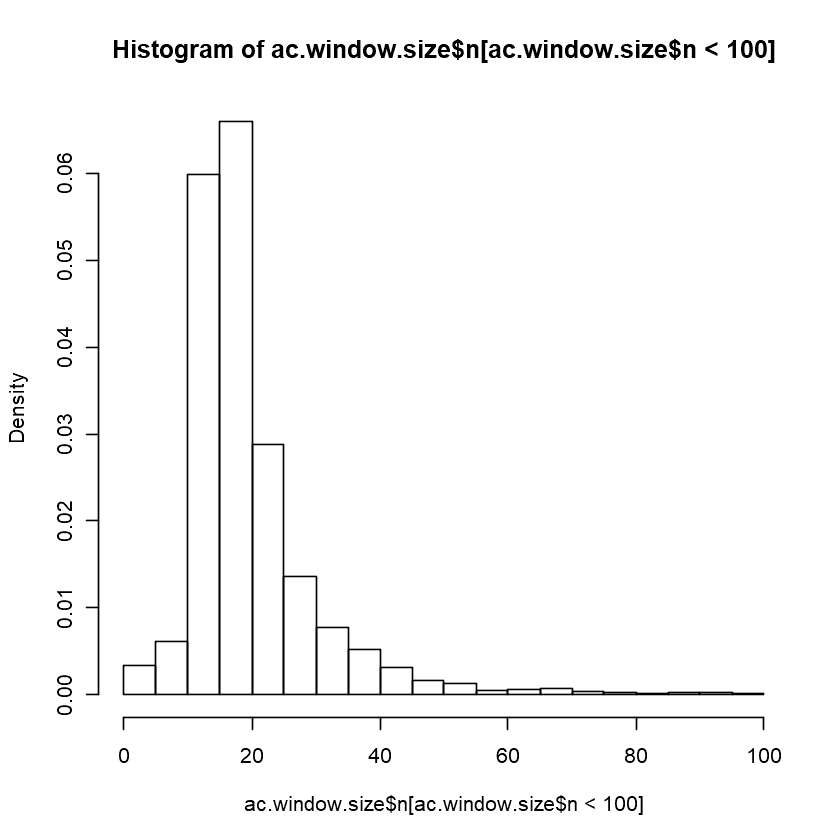

In [21]:
#plot a histogram for activation window of ac
hist(ac.window.size$n[ac.window.size$n<100],freq=FALSE)

In [22]:
#activation window for ac seems to be predominantly around 10 to 30
#Hence, create difference with lag 10 to lag 30
for (i in 10:30){
    ac.data[,paste0('difflag',i)]<-ac.data$load-lag(ac.data$load,i,na.pad=TRUE)
}
ac.data<-ac.data[-15]

#Also generate the same difflag variables for ac test data
ac.test<-test.dat
for (i in 10:30){
    ac.test[,paste0('difflag',i)]<-ac.test$load-lag(ac.test$load,i,na.pad=TRUE)
}

#### Generate `difflag` variables for `ev`

In [23]:
ev.data<-train.data

#Extract only target column ev
ev.data<-ev.data %>% select(-c(3,5,6,7))

#Create ev_grp that increments on the difference of ac
ev.data$ev_grp <- cumsum(c(0,as.numeric(diff(ev.data$ev))!=0))

#Get the data where ev=1
ev.data.1<-ev.data[ev.data$ev==1,]

#Get the count of ev_grp, hence obtain all the values of activation window for ev
ev.window.size<-ev.data.1 %>% count(ev_grp)
summary(ev.window.size$n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00    9.00   18.00   80.52  157.00  239.00 

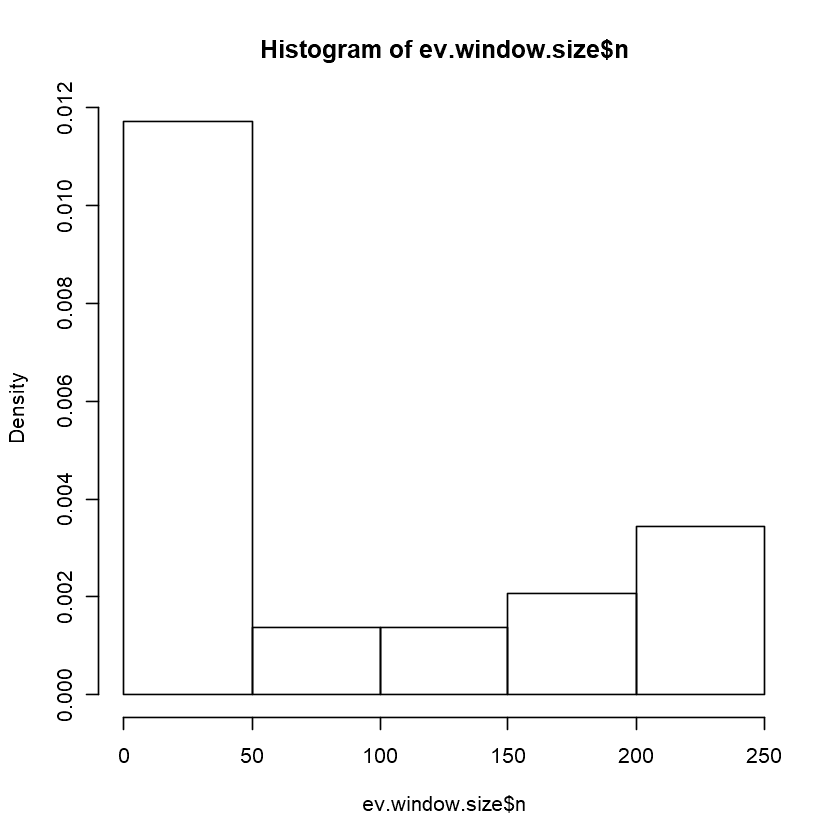

In [24]:
# hist(ac.window.size$n[ac.window.size$n<100],freq=FALSE)
hist(ev.window.size$n,freq=FALSE)

In [25]:
#activation window for ev are much more spread out compared to ac, so we consider a wider range of values 
ev.lag<-c(10, 12, 14, 16, 18, 20, 50, 100, 120, 140, 160, 180, 200, 220, 240)
for (i in ev.lag){
    ev.data[,paste0('difflag',i)]<-ev.data$load-lag(ev.data$load,i,na.pad=TRUE)
}
ev.data<-ev.data[-15]

#Also generate the same difflag variables for ev test data
ev.test<-test.dat
for (i in ev.lag){
    ev.test[,paste0('difflag',i)]<-ev.test$load-lag(ev.test$load,i,na.pad=TRUE)
}

#### Generate `difflag` variables for `oven`

In [26]:
oven.data<-train.data

#Extract only target column oven
oven.data<-oven.data %>% select(-c(3,4,6,7))

##Create oven_grp that increments on the difference of oven
oven.data$oven_grp <- cumsum(c(0,as.numeric(diff(oven.data$oven))!=0))

#Get the data where oven=1
oven.data.1<-oven.data[oven.data$oven==1,]

#Get the count of oven_grp, hence obtain all the values of activation window for oven
oven.window.size<-oven.data.1 %>% count(oven_grp)
summary(oven.window.size$n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   3.000   5.568   5.000 143.000 

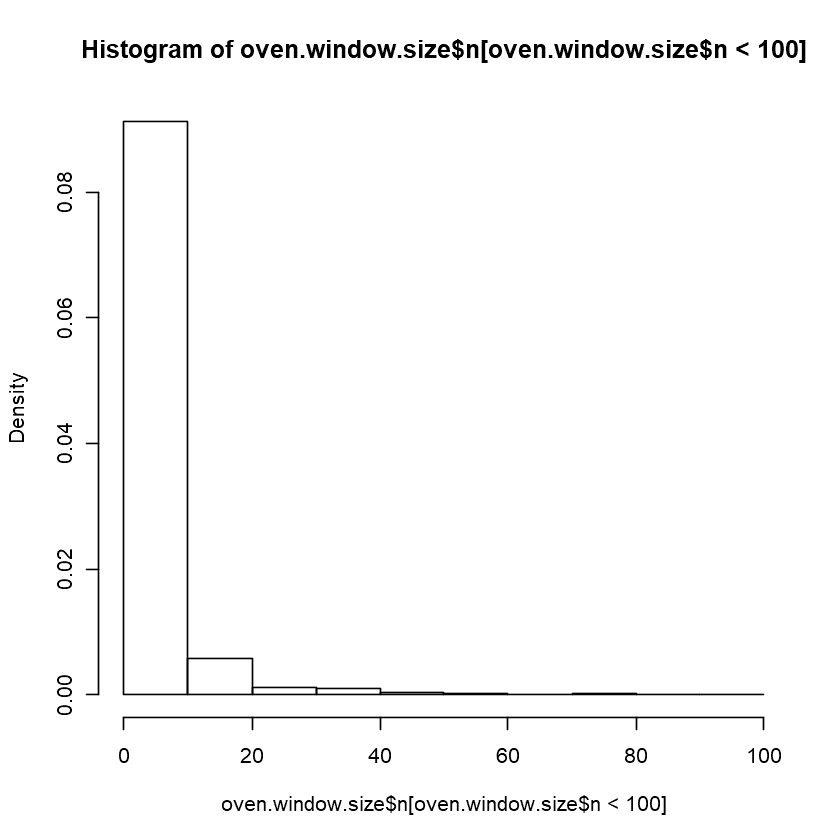

In [27]:
hist(oven.window.size$n[oven.window.size$n<100],freq=FALSE)

In [28]:
#activation window for oven is mainly around 1 to 20 
#Hence, create difference with lag 2 to lag 20
for (i in 2:20){
    oven.data[,paste0('difflag',i)]<-oven.data$load-lag(oven.data$load,i,na.pad=TRUE)
}
oven.data<-oven.data[-15]

#Also generate the same difflag variables for oven test data
oven.test<-test.dat
for (i in 2:20){
    oven.test[,paste0('difflag',i)]<-oven.test$load-lag(oven.test$load,i,na.pad=TRUE)
}

#### Generate `difflag` variables for `wash`

In [29]:
wash.data<-train.data

#Extract only target column wash
wash.data<-wash.data %>% select(-c(3,4,5,7))

##Create wash_grp that increments on the difference of wash
wash.data$wash_grp <- cumsum(c(0,as.numeric(diff(wash.data$wash))!=0))

#Get the data where wash=1
wash.data.1<-wash.data[wash.data$wash==1,]

#Get the count of wash_grp, hence obtain all the values of activation window for wash
wash.window.size<-wash.data.1 %>% count(wash_grp)
summary(wash.window.size$n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   6.387   5.000 103.000 

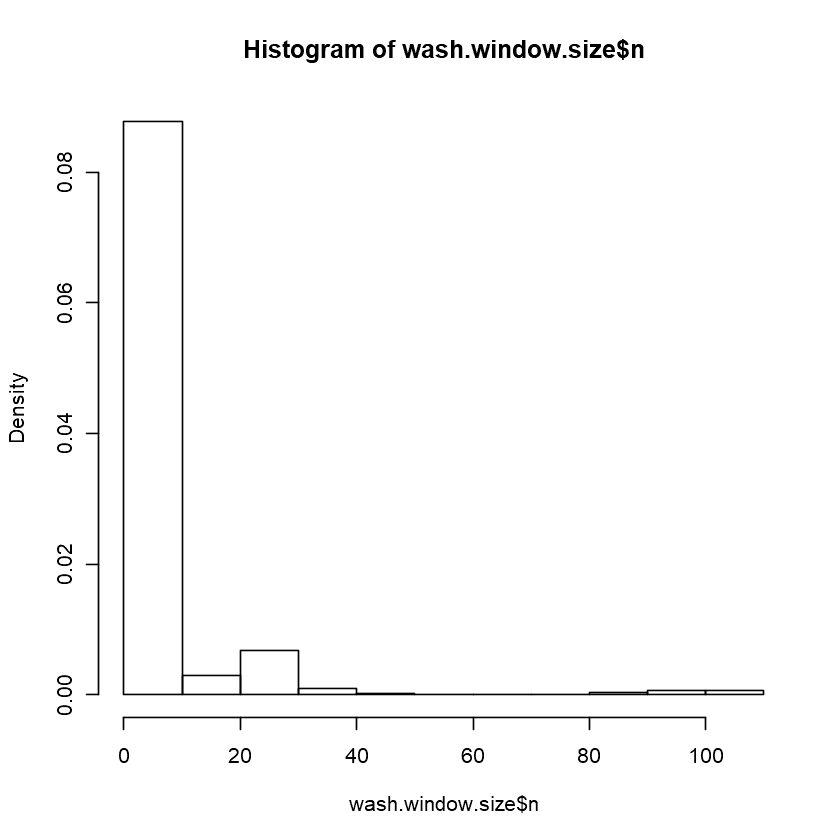

In [30]:
hist(wash.window.size$n,freq=FALSE)

In [31]:
#activation window for wash is mainly around 1 to 20 
#Hence, create difference with lag 2 to lag 20
for (i in 2:20){
    wash.data[,paste0('difflag',i)]<-wash.data$load-lag(wash.data$load,i,na.pad=TRUE)
}
wash.data<-wash.data[-15]

#Also generate the same difflag variables for wash test data
wash.test<-test.dat
for (i in 2:20){
    wash.test[,paste0('difflag',i)]<-wash.test$load-lag(wash.test$load,i,na.pad=TRUE)
}

#### Generate `difflag` variables for `dryer`

In [32]:
dryer.data<-train.data

#Extract only target column dryer
dryer.data<-dryer.data %>% select(-c(3,4,5,6))

##Create dryer_grp that increments on the difference of dryer
dryer.data$dryer_grp <- cumsum(c(0,as.numeric(diff(dryer.data$dryer))!=0))

##Get the data where dryer=1
dryer.data.1<-dryer.data[dryer.data$dryer==1,]

##Get the count of dryer_grp, hence obtain all the values of activation window for dryer
dryer.window.size<-dryer.data.1 %>% count(dryer_grp)
summary(dryer.window.size$n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   45.00   87.00   88.09  135.00  177.00 

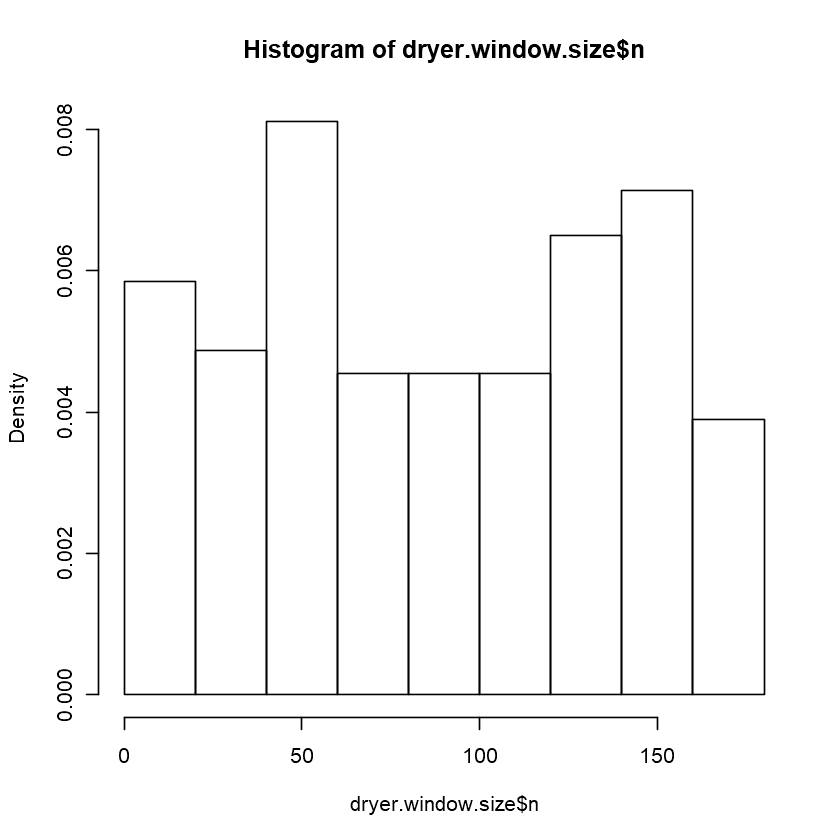

In [33]:
hist(dryer.window.size$n,freq=FALSE)

In [34]:
#Activation windows of dryer have no most commonly-occurred range, take on different range of values almost equally
#Hence, create difference with lag 20 to lag 180, step by 10
dryer.lag<-seq(20,180,10)
for (i in dryer.lag){
    dryer.data[,paste0('difflag',i)]<-dryer.data$load-lag(dryer.data$load,i,na.pad=TRUE)
}
dryer.data<-dryer.data[-15]

#Also generate the same difflag variables for dryer test data
dryer.test<-test.dat
for (i in dryer.lag){
    dryer.test[,paste0('difflag',i)]<-dryer.test$load-lag(dryer.test$load,i,na.pad=TRUE)
}

Since there are severe class imbalance issue in this data, we will make use of `f1 score` as the evaluation metrics. Now, we define a function to help us get f1 score from the actual true label and the prediction

In [35]:
f1<-function(truth,predict){
    conf.mat<-table(truth,predict)
    precision<-(conf.mat[2,2])/(conf.mat[2,2]+conf.mat[1,2])
    recall<-(conf.mat[2,2])/(conf.mat[2,2]+conf.mat[2,1])
    #handle zero division
    f1_score<-ifelse(conf.mat[2,2]==0,0,2*(precision*recall)/(precision+recall))
    return (f1_score)
}

### Summary of pre-processing, EDA and Feature Engineering

When inspecting the data, we found various rows of data that violate the sequential structure associated with a time-series data, as their `hourofday` or `dayofweek` or both variables are inconsistent with preceding rows or succeeding rows or both. We filter out these rows of data. Afterwards, we recalculate `dif` and `absdif` variables for the sake of consistency of time-series data

For feature engineering, there are 3 main types of variables that we generate, which are `minuteofhour` variable, `minuteofday` variable and `difflag` variables. 
- `Minuteofhour` variable is the minute within each hour, derived from `hourofday` variable. 
- `minuteofday` variable is the minute within each day, derived from `dayofweek` variable. 
- `difflag` variables are the difference between the value of `load` variable and its corresponding lag. For example, `difflag10` variable is the difference between the value of `load` and the 10th lag of value of `load`. In order to know what kind of `difflag` would be the most appropriate for each target variable, we need to consider their activation window. Since appliances usage lasts for a while, this activation window can be insightful and help us decide what values of `difflag` to consider. Each appliance has different activation window, so each appliance might have different `difflag` variables. We also need to narrow down what would be the optimal activation window sizes, for each target variable. For example, for target variable `ac`, consecutive rows of data where ac are all equal to 1 are grouped together. Then we count the number of rows within each of this group. This count is the value of activation window of `ac`. Then we plot a histogram to show the distribution of the values of activation window. Based on this histogram, we consider the most-commonly occurred activation window and generate `difflag` variables based on that. Due to the generation of `difflag` variables, there will be NaN entries in the test set, as we don’t have the corresponding lag of load variable. We simply pad these NaN entries with 0 in the test set.

In the classifier that we will build later, we make use of all the variables, both original and newly generated.

## 2. Model Development <a class="anchor" id="2"></a>

In this project, I will attempt to use Random Forest classifier to model all 5 appliances. 

The simplest unit of Random Forest is a single decision tree. However, if we use 1 single decision tree to fit the training data, a single decision tree is known to overfit on training data, with a low bias but a high variance. This results in a poor generalization on the test data, hence leading to a poor prediction performance by 1 single decision tree. 

Random Forest overcomes this problem in 2 ways. 
- The first way is to not only rely on 1 single decision tree, but average the results from multiple trees so as to reduce the variance. However, this is not enough as multiple correlated trees with high variance will still lead to a poor result.
- Therefore, the second way is Random Forest also only selects a `random subset of predictors` as split candidates for different trees, in order to prevent the situation where there are some very dominant predictors which might be selected all the time as split candidates in all the trees. As a result, very different, de-correlated trees are generated instead, so the average results across all these trees will be better.

1 problem is to determine how many predictors should be included in this `random subset of predictors`. Rule of thumb for `classification case` is the **square root of the total number of features**. For our case, since all of the target variables have around 30 to 36 associated features, we will use 5 to 6 predictors for this `random subset of predictors`.

### Experimental setup

Since what we have here is time-series data, usual k-fold cross validation is inappropriate. Just like how it is not sensible to use the future information to predict the past information, it is also not sensible to train on 'future' folds and then validate on a 'past' fold. For this reason, we will implement **cross validation on a rolling basis**, which I will refer to as rolling fold cross validation. We only **train on 'past' folds and then validate on a 'future' fold**. For our case, we split the data into 4 folds: fold 1, fold 2, fold 3 and fold 4. By splitting a time-series in this way, fold 1 will include all the data that is the oldest, followed by fold 2, then fold 3, and then fold 4 has all the newest data. To perform rolling fold cross validation, in the first iteration, we train on fold 1 and validate on fold 2. Then, in the next iteration, we rowbind fold 2 to fold 1 (to preserve the structure of time-series data) as a new fold, train the model on this new fold, and then validate on fold 3 and so on. By performing cross validation in this way, we still **preserve the sequential nature of data in a time-series dataset**.

Apart from cross validation, there is another issue that we need to address. It is **class imbalance** issue. Besides `ac`, all the remaining target variables like `ev`, `oven`, `wash` and `dryer` suffer from severe class imbalance issue, with the proportion of positive class being about only 1% of the total observation. Without addressing this issue, models trained on this data will misclassify most, if not all, of the positive class as negative class. We choose to implement **resampling** to tackle this problem. There are 2 ways of resampling: oversampling or undersampling. Originally, I proceeded with oversampling as I thought this is clearly the better choice. Our reasoning was that theoretically, it should always be better to train on more data, so the model has more data to learn from. However, soon enough, we realize that the difficulty of practical implementation overshadows any theoretical benefits. We face with 2 main challenges if we decide to implement oversampling to solve the problem of class imbalance. The first challenge is that the given training set size is already very large, with more than 400000 rows. If we want to resample the data such that the proportion of the minority positive class is no longer imbalanced, we would need to include about 200000 to 300000 additional rows. This means the total training size can get to about 600000 to 700000 data points. Due to time and resource constraint, we do not think it is very practical to train on such a large amount of data, with different target variables, various rolling fold cross validation, tuning of hyperparameters and such a high dimensional feature space. The second challenge is that there does not seem to be any well-established existing code documentation and implementation when it comes to oversampling of a time-series data. Most of the existing oversampling methods are for data that are not time-series.

Therefore, we decide to implement **undersampling** instead. This undersampling is done in such a way that we try to **preserve the structure of the time-series as best as possible**. Firstly, we need to consider each activation window where there are consecutive rows of data where the target variable is equal to 1. Then, we get a certain number of rows that precedes these consecutive rows of data, as well as a certain number of rows that succeeds these consecutive rows of data. Essentially, we extract a segment from the original time-series data where each segment contains a number of consecutive rows where the target variable is equal to 0, followed by a number of consecutive rows where the target variable is equal to 1, and lastly followed by a number of consecutive rows where the target variable is back to be 0. The structure of time-series data is preserved because the data within each segment is simply the data extracted from the original time-series data, **without any reordering of rows**. By undersampling this way, the proportion of classes of the target variable is much more balanced now. For a better visualization of this method of undersampling, please refer to the image here. Therefore, we use this undersampled data to split on and perform rolling fold cross validation.

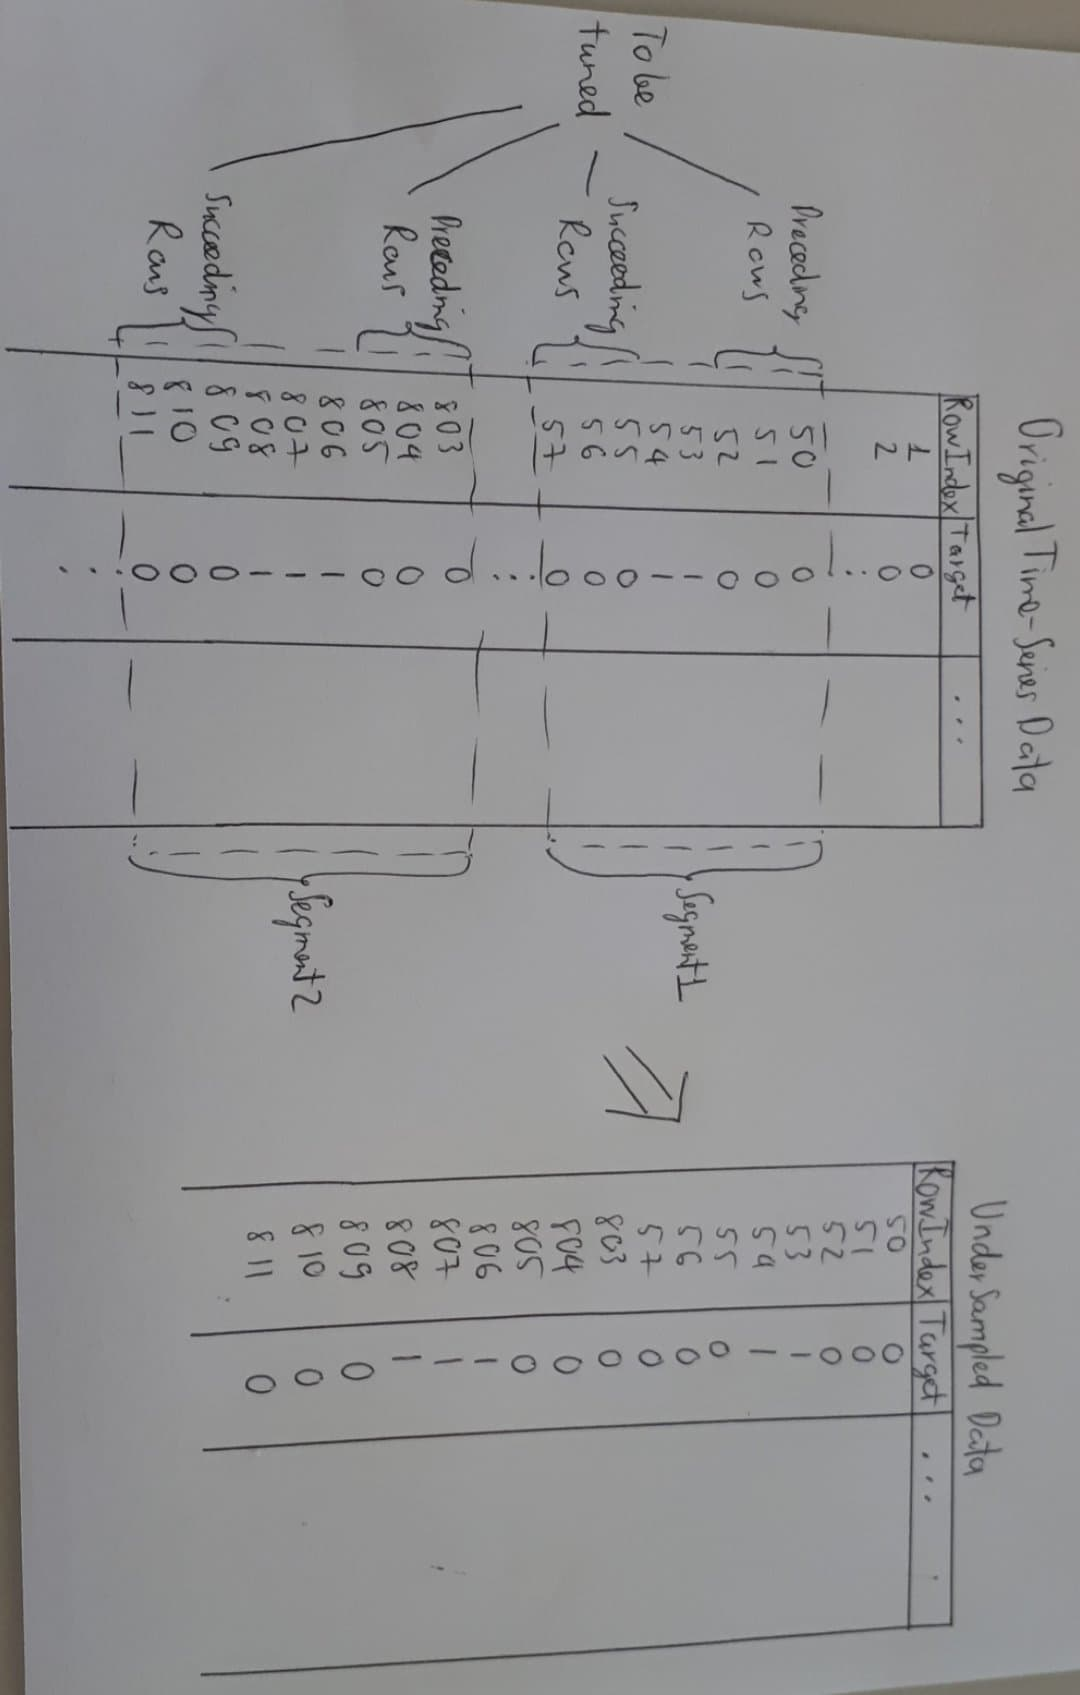

We mentioned this concept of `a certain number of rows` that precedes and succeeds the consecutive rows of data where the target variable is equal to 1. This ‘certain number of rows’ is a **hyperparameter** that we will tune using **rolling fold cross validation**. There are other hyperparameters that we will tune as well. For example, number of trees for Random Forest.

The evaluation metrics to compare the performance of different settings of models is f1 score. F1 score can be computed following the formula given, with Precision and Recall. Since `ac` does not have class imbalance issue like others, initially, we decide to use the whole training data to split and perform rolling fold cross validation. Afterwards, we notice that about 160000 last rows of data all have ac equal to 0. This is problematic because when we split the data into folds, validation folds that are within these 160000 last rows will result in the value of true positive being 0, complicating the results of the rolling fold cross validation. Therefore, we decide to resample the data for ac such that the new training set only consists of the first 300000 rows in the time-series data. By doing this, we ensure that when we split, the validation folds will have some rows where ac is equal to 1.

For each appliance, after getting the best combination of hyperparameters through rolling fold cross validation, we retrain the model with this best combination, on the resampled data. To get f1 score for each appliance, we use this model to output the prediction for the whole training set, and get f1 score for the whole training set. Since there are 5 appliances, we will get 5 f1 scores. We sum them up and divide by 5 to get the average f1 score.

### Build classifier for `ac`

In [36]:
table(ac.data$ac)


     0      1 
316267 101103 

There is no severe class imbalance issue for `ac`

In [37]:
#Get rid of X column
ac.data<-ac.data[-1]
#Get only rows where ac=1
ac.only<-ac.data[ac.data$ac==1,]
head(ac.only)

,load,ac,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,...,difflag21,difflag22,difflag23,difflag24,difflag25,difflag26,difflag27,difflag28,difflag29,difflag30
24,3.361,1,0,Sun,0.941,0.941,6.215,3.208320,0.6568986,0.3055014,...,1.092,1.102,1.116,NA,NA,NA,NA,NA,NA,NA
25,6.167,1,0,Sun,2.806,2.806,6.215,3.209429,0.6483738,0.3068348,...,3.899,3.898,3.908,3.922,NA,NA,NA,NA,NA,NA
26,6.204,1,0,Sun,0.037,0.037,6.215,3.210533,0.6323101,0.3064766,...,3.934,3.936,3.935,3.945,3.959,NA,NA,NA,NA,NA
27,6.215,1,0,Sun,0.011,0.011,6.215,3.211904,0.6157109,0.3029531,...,3.956,3.945,3.947,3.946,3.956,3.970,NA,NA,NA,NA
28,6.207,1,0,Sun,-0.008,0.008,6.215,3.210240,0.6082089,0.3023561,...,3.957,3.948,3.937,3.939,3.938,3.948,3.962,NA,NA,NA
29,6.199,1,0,Sun,-0.008,0.008,6.215,3.208092,0.6153455,0.3016025,...,3.948,3.949,3.940,3.929,3.931,3.930,3.940,3.954,NA,NA


In [38]:
#the last seen observation where ac=1 is row with index 256731
tail(ac.only)

,load,ac,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,...,difflag21,difflag22,difflag23,difflag24,difflag25,difflag26,difflag27,difflag28,difflag29,difflag30
256726,4.161,1,23,Wed,0.033,0.033,5.528,2.124582,0.6717405,0.6583473,...,3.203,3.201,3.206,3.192,3.193,3.191,3.198,3.197,3.211,3.211
256727,4.159,1,23,Wed,-0.002,0.002,5.528,2.136711,0.6752240,0.6627708,...,3.206,3.201,3.199,3.204,3.190,3.191,3.189,3.196,3.195,3.209
256728,4.125,1,23,Wed,-0.034,0.034,5.528,2.148734,0.6735393,0.6662568,...,3.171,3.172,3.167,3.165,3.170,3.156,3.157,3.155,3.162,3.161
256729,4.116,1,23,Wed,-0.009,0.009,5.528,2.160962,0.6689354,0.6729648,...,3.164,3.162,3.163,3.158,3.156,3.161,3.147,3.148,3.146,3.153
256730,4.116,1,23,Wed,0.000,0.000,5.528,2.172718,0.6635515,0.6778273,...,3.163,3.164,3.162,3.163,3.158,3.156,3.161,3.147,3.148,3.146
256731,3.965,1,23,Wed,-0.151,0.151,5.528,2.184972,0.6588178,0.6891294,...,3.020,3.012,3.013,3.011,3.012,3.007,3.005,3.010,2.996,2.997


In [39]:
dim(ac.data)
cat('The last',dim(ac.data)[1]-256731,'rows of ac.data have ac all equal to 0')

[1] 417370     34

The last 160639 rows of ac.data have ac all equal to 0

This is problematic because later on when we split the data into training and validation to do cross validation, if any validation split is within these 160639 rows, f1 score will be 0. So we train the classifier only on the first 300000 rows of `ac.data`

In [41]:
ac.sampling=ac.data[1:300000,]

We build a randomForest classfier to model `ac`

In [42]:
#train/valid split for time-series -> rolling basis
#split into 4 non-overlapping, equal-in-size folds
ac.split<-split(ac.sampling,(as.numeric(rownames(ac.sampling))-1) %/% floor(nrow(ac.sampling)/4+1))

#training folds
train.ac.f1<-ac.split$'0'
train.ac.f2<-rbind(train.ac.f1,ac.split$'1')
train.ac.f3<-rbind(train.ac.f2,ac.split$'2')

#validation folds
val.ac.f1<-ac.split$'1'
val.ac.f2<-ac.split$'2'
val.ac.f3<-ac.split$'3'

In [43]:
#cross validation to tune the number of tree
#For reproducibility
set.seed(1)

#Initialize an empty dataframe to store the tree and its resulting f1
ac.evaluation<-data.frame()

#No of trees to consider
no.tree<-seq(150,300,25)
counter<-1

#For each tree
for (j in no.tree){
    f1.j<-c()
    
    #perform 3-rolling-fold cross validation
    for (i in 1:3){
        
        #get the earlier fold as training fold
        train=eval(as.name(paste0('train.ac.f',i)))
        #get later fold as validation fold
        valid=eval(as.name(paste0('val.ac.f',i)))
        
        #train the randomforest for ac
        ac.rf=randomForest(ac~.,data=train,mtry=6,ntree=j,na.action=na.omit)
        
        #get the prediction on validation fold
        pred<-predict(ac.rf,newdata=valid)
        
        #compute f1
        f1.score<-f1(valid$ac,pred)
        f1.j<-c(f1.j,f1.score)
    }
    
    #get the average f1 for cross validation
    ac.f1<-sum(f1.j)/length(f1.j)
    
    #store values in dataframe
    ac.evaluation[counter,'no_tree']<-j
    ac.evaluation[counter,'f1_score']<-ac.f1
    counter<-counter+1
}

In [44]:
ac.evaluation

no_tree,f1_score
150,0.8954407
175,0.8925917
200,0.8893592
225,0.8906719
250,0.8943096
275,0.8907099
300,0.8913951


In [45]:
#Get the value of tree that results in the highest cross validated f1 score
ac.evaluation[ac.evaluation$f1_score==max(ac.evaluation$f1_score),]

no_tree,f1_score
150,0.8954407


In [46]:
#retrain the model on the whole ac.sampling data with the best value of tree
set.seed(1)
ac.rf<-randomForest(ac~.,data=ac.sampling,mtry=6,ntree=150,na.action=na.omit,importance=TRUE)

In [47]:
#get the prediction on the whole ac.data
rf.ac.pred<-predict(ac.rf,ac.data)

#compute confusion matrix
confusionMatrix(table(truth=ac.data$ac,predict=rf.ac.pred),positive='1') #perfect on training set

Confusion Matrix and Statistics

     predict
truth      0      1
    0 315489    755
    1      0 101096
                                          
               Accuracy : 0.9982          
                 95% CI : (0.9981, 0.9983)
    No Information Rate : 0.756           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9951          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9926          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9976          
             Prevalence : 0.2440          
         Detection Rate : 0.2422          
   Detection Prevalence : 0.2422          
      Balanced Accuracy : 0.9963          
                                          
       'Positive' Class : 1               
                                  

In [48]:
#Get f1 score
ac.f1<-f1(ac.data$ac,rf.ac.pred)
ac.f1

[1] 0.9962798

Using Random Forest, we manage to get a very high `f1 score`, predicting `ac`

###  Build classifier for `ev`

In [49]:
table(ev.data$ev) #severe class imbalance issue


     0      1 
415035   2335 

In [50]:
#Remove X column
ev.data<-ev.data[-1]

#Quite a number of features
colnames(ev.data)

[1] "load"         "ev"           "hourofday"    "dayofweek"    "dif"         
 [6] "absdif"       "max"          "var"          "entropy"      "nonlinear"   
[11] "hurst"        "minuteofhour" "minuteofday"  "difflag10"    "difflag12"   
[16] "difflag14"    "difflag16"    "difflag18"    "difflag20"    "difflag50"   
[21] "difflag100"   "difflag120"   "difflag140"   "difflag160"   "difflag180"  
[26] "difflag200"   "difflag220"   "difflag240"

In [51]:
#get the data where ev=1
ev.only=ev.data[ev.data$ev==1,]
ev.only

,load,ev,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,...,difflag20,difflag50,difflag100,difflag120,difflag140,difflag160,difflag180,difflag200,difflag220,difflag240
41431,8.314,1,18,Sun,2.614,2.614,9.285,2.781009,0.6375875,0.3256382,...,2.965,1.772,2.662,2.836,2.209,2.723,2.851,2.612,6.126,2.922
41432,8.923,1,18,Sun,0.609,0.609,9.285,2.763901,0.6290902,0.3137919,...,3.569,1.448,3.250,3.456,3.240,3.327,3.480,3.249,6.900,3.549
41433,8.825,1,18,Sun,-0.098,0.098,9.285,2.740749,0.6130937,0.3160131,...,3.480,1.591,3.173,3.390,3.136,3.256,3.377,3.136,7.617,3.433
41434,8.767,1,18,Sun,-0.058,0.058,9.285,2.711568,0.5991761,0.3196799,...,3.393,2.733,3.288,3.306,2.792,3.169,3.296,3.051,7.644,3.374
41435,8.773,1,18,Sun,0.006,0.006,9.285,3.296712,0.5982351,0.1595938,...,3.372,3.191,2.501,3.341,1.820,3.181,3.328,3.074,7.625,3.421
41436,8.729,1,18,Sun,-0.044,0.044,9.285,3.265573,0.6239193,4.2282557,...,3.340,3.144,2.202,3.263,3.042,3.244,3.351,3.118,7.550,3.354
41437,8.712,1,18,Sun,-0.017,0.017,9.285,3.226303,0.6794117,4.1929970,...,3.323,2.947,2.220,3.183,2.986,3.224,3.361,3.067,7.519,3.308
41438,8.720,1,18,Sun,0.008,0.008,9.285,3.180909,0.7502596,4.1500883,...,3.325,2.975,2.282,3.175,3.016,3.250,3.400,3.096,7.510,3.300
41439,8.726,1,18,Sun,0.006,0.006,9.285,3.127205,0.8145681,4.1047609,...,3.155,2.990,2.298,3.105,3.040,3.220,3.241,3.084,7.504,3.247
41440,8.761,1,18,Sun,0.035,0.035,9.285,3.068804,0.8591845,4.0546091,...,3.183,2.456,2.516,3.060,3.076,3.186,3.160,3.061,7.536,3.319


We build Random Forest classifier to model `ev`

In [52]:
#tuning the number of precede/succeed rows and tree that maximize f1 
bestrow<-data.frame()
row.counter<-1

#Consider a range of number of precede/succeed rows
row.sampling<-seq(150,300,10)
for (r in row.sampling){
    
    #Get the row index of rows that precedes the rows in ev.only by r rows
    ev.precede=as.character(as.numeric(rownames(ev.only))-r)
    
    #Get the row index of rows that succeeds the rows in ev.only by r rows
    ev.succeed=as.character(as.numeric(rownames(ev.only))+r)
    
    #Extract the segment in the original time series data that contain these ev.only/preceded/succeed rows
    ev.sampling=ev.data[rownames(ev.data) %in% c(rownames(ev.only),ev.precede,ev.succeed),]
    
    #Reset the row index
    row.names(ev.sampling) <- NULL
    
    #train/valid split for time-series -> rolling basis
    ev.split<-split(ev.sampling,(as.numeric(rownames(ev.sampling))-1) %/% floor(nrow(ev.sampling)/4+1))
    
    #training folds
    train.ev.f1<-ev.split$'0'
    train.ev.f2<-rbind(train.ev.f1,ev.split$'1')
    train.ev.f3<-rbind(train.ev.f2,ev.split$'2')

    #validation folds
    val.ev.f1<-ev.split$'1'
    val.ev.f2<-ev.split$'2'
    val.ev.f3<-ev.split$'3'
    
    #For reproducibility
    set.seed(1)
    ev.evaluation<-data.frame()
    
    #Number of trees to consider
    no.tree<-seq(140,500,20)  
    counter<-1
    for (j in no.tree){
        f1.j<-c()
        
        #Perform 3-rolling-fold cross validation
        for (i in 1:3){
            
            #Get the earlier fold as training fold
            train=eval(as.name(paste0('train.ev.f',i)))
            
            #Get the later fold as validation fold
            valid=eval(as.name(paste0('val.ev.f',i)))
            
            #train the randomForest for ev
            ev.rf=randomForest(ev~.,data=train,mtry=5,ntree=j,na.action=na.omit)
            
            #Get prediction on validation fold
            pred<-predict(ev.rf,newdata=valid)
            
            #compute f1
            f1.score<-f1(valid$ev,pred)
            f1.j<-c(f1.j,f1.score)
        }
        
        #get the average f1 for cross validation
        ev.f1<-sum(f1.j)/length(f1.j)
        
        #store values in dataframe
        ev.evaluation[counter,'no_tree']<-j
        ev.evaluation[counter,'f1_score']<-ev.f1
        counter<-counter+1
    }
    #Get the value of tree that results in the highest cross validated f1 score
    best.tree<-ev.evaluation[ev.evaluation$f1_score==max(ev.evaluation$f1_score),]
    
    #retrain the model on the whole ev.sampling with the best value of tree
    ev.rf<-randomForest(ev~.,data=ev.sampling,mtry=5,ntree=best.tree$no_tree,na.action=na.omit)
    
    #get prediction and f1 for the whole ev.data
    rf.ev.pred<-predict(ev.rf,ev.data)
    ev.f1<-f1(ev.data$ev,rf.ev.pred)
    
    #Store values in dataframe for comparison later
    bestrow[row.counter,'row_sampling']<-r  
    bestrow[row.counter,'no_tree']<-best.tree$no_tree
    bestrow[row.counter,'f1_score']<-ev.f1
    row.counter<-row.counter+1
}

In [53]:
bestrow

row_sampling,no_tree,f1_score
150,320,0.1557342
160,220,0.2027526
170,160,0.2216527
180,400,0.2214005
190,160,0.1806507
200,140,0.2012411
210,140,0.2344260
220,160,0.2279606
230,400,0.2144366
240,220,0.2319805


In [54]:
#Get the best combination of row_sampling and no_tree that results in the highest f1 score
ev.bestrow<-bestrow[bestrow$f1_score==max(bestrow$f1_score),]
ev.bestrow

,row_sampling,no_tree,f1_score
14,280,220,0.2806153


In [55]:
set.seed(1)

#Get the number of preceded and succeeded rows based on best value of row_sampling
ev.precede=as.character(as.numeric(rownames(ev.only))-ev.bestrow$row_sampling)
ev.succeed=as.character(as.numeric(rownames(ev.only))+ev.bestrow$row_sampling)

#get the undersampling
ev.sampling=ev.data[rownames(ev.data) %in% c(rownames(ev.only),ev.precede,ev.succeed),]

#reset row index 
row.names(ev.sampling) <- NULL

#retrain the model with best tree
ev.rf<-randomForest(ev~.,data=ev.sampling,mtry=5,ntree=ev.bestrow$no_tree,na.action=na.omit,importance=TRUE)

In [56]:
#Get prediction on the whole ev.data
rf.ev.pred<-predict(ev.rf,ev.data)

#compute confusion matrix
confusionMatrix(table(truth=ev.data$ev,predict=rf.ev.pred),positive='1') 

Confusion Matrix and Statistics

     predict
truth      0      1
    0 402951  11844
    1      0   2335
                                          
               Accuracy : 0.9716          
                 95% CI : (0.9711, 0.9721)
    No Information Rate : 0.966           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2758          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.164680        
            Specificity : 1.000000        
         Pos Pred Value : 1.000000        
         Neg Pred Value : 0.971446        
             Prevalence : 0.033992        
         Detection Rate : 0.005598        
   Detection Prevalence : 0.005598        
      Balanced Accuracy : 0.582340        
                                          
       'Positive' Class : 1               
                                  

In [57]:
#get f1 score
ev.f1<-f1(ev.data$ev,rf.ev.pred)
ev.f1

[1] 0.2827904

###  Build classifier for `oven`

In [58]:
table(oven.data$oven)  #severe imbalance data


     0      1 
411418   5952 

In [59]:
#Remove X column
oven.data<-oven.data[-1]

#Quite a number of features
colnames(oven.data)

[1] "load"         "oven"         "hourofday"    "dayofweek"    "dif"         
 [6] "absdif"       "max"          "var"          "entropy"      "nonlinear"   
[11] "hurst"        "minuteofhour" "minuteofday"  "difflag2"     "difflag3"    
[16] "difflag4"     "difflag5"     "difflag6"     "difflag7"     "difflag8"    
[21] "difflag9"     "difflag10"    "difflag11"    "difflag12"    "difflag13"   
[26] "difflag14"    "difflag15"    "difflag16"    "difflag17"    "difflag18"   
[31] "difflag19"    "difflag20"

In [60]:
#get the data where oven=1
oven.only=oven.data[oven.data$oven==1,]
oven.only

,load,oven,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,...,difflag11,difflag12,difflag13,difflag14,difflag15,difflag16,difflag17,difflag18,difflag19,difflag20
5362,6.750,1,17,Wed,1.371,1.371,9.354,10.092184,0.6628366,0.030252135,...,5.858,5.857,5.823,5.854,5.835,5.838,5.822,5.835,5.840,5.859
5363,9.265,1,17,Wed,2.515,2.515,9.354,10.105807,0.6693228,0.055347267,...,8.334,8.373,8.372,8.338,8.369,8.350,8.353,8.337,8.350,8.355
5364,9.256,1,17,Wed,-0.009,0.009,9.354,10.130380,0.6769156,0.039804808,...,8.319,8.325,8.364,8.363,8.329,8.360,8.341,8.344,8.328,8.341
5365,9.294,1,17,Wed,0.038,0.038,9.354,10.264551,0.6843180,0.006092936,...,8.374,8.357,8.363,8.402,8.401,8.367,8.398,8.379,8.382,8.366
5366,9.270,1,17,Wed,-0.024,0.024,9.354,10.468929,0.6908852,0.030116179,...,4.534,8.350,8.333,8.339,8.378,8.377,8.343,8.374,8.355,8.358
5367,9.298,1,17,Wed,0.028,0.028,9.354,10.526459,0.6965662,0.045994688,...,3.979,4.562,8.378,8.361,8.367,8.406,8.405,8.371,8.402,8.383
5368,9.340,1,17,Wed,0.042,0.042,9.354,10.534822,0.7003658,0.049685245,...,3.998,4.021,4.604,8.420,8.403,8.409,8.448,8.447,8.413,8.444
5369,9.346,1,17,Wed,0.006,0.006,9.354,10.389594,0.7024151,0.043831873,...,4.031,4.004,4.027,4.610,8.426,8.409,8.415,8.454,8.453,8.419
5370,9.354,1,17,Wed,0.008,0.008,9.354,10.129202,0.7044260,0.094764050,...,4.018,4.039,4.012,4.035,4.618,8.434,8.417,8.423,8.462,8.461
5371,9.349,1,17,Wed,-0.005,0.005,9.354,9.960115,0.7080203,0.032329456,...,3.998,4.013,4.034,4.007,4.030,4.613,8.429,8.412,8.418,8.457


In [61]:
#Build random Forest classifier to model oven
#tuning the number of precede/succeed rows and tree that maximize f1 
bestrow<-data.frame()
row.counter<-1

#Consider a range of number of precede/succeed rows
row.sampling<-seq(10,150,10)
for (r in row.sampling){
    
    #Get the row index of rows that precedes the rows in oven.only by r rows
    oven.precede=as.character(as.numeric(rownames(oven.only))-r)
    
    #Get the row index of rows that succeeds the rows in oven.only by r rows
    oven.succeed=as.character(as.numeric(rownames(oven.only))+r)
    
    #Extract the segment in the original time series data that contain these oven.only/preceded/succeed rows
    oven.sampling=oven.data[rownames(oven.data) %in% c(rownames(oven.only),oven.precede,oven.succeed),]
    
    #Reset the row index
    row.names(oven.sampling) <- NULL
    
    #train/valid split for time-series -> rolling basis
    oven.split<-split(oven.sampling,(as.numeric(rownames(oven.sampling))-1) %/% floor(nrow(oven.sampling)/4+1))
    
    #training folds
    train.oven.f1<-oven.split$'0'
    train.oven.f2<-rbind(train.oven.f1,oven.split$'1')
    train.oven.f3<-rbind(train.oven.f2,oven.split$'2')

    #validation folds
    val.oven.f1<-oven.split$'1'
    val.oven.f2<-oven.split$'2'
    val.oven.f3<-oven.split$'3'
    
    #For reproducibility
    set.seed(1)
    oven.evaluation<-data.frame()
    
    #Number of trees to consider
    no.tree<-seq(140,300,20)  
    counter<-1
    for (j in no.tree){
        f1.j<-c()
        
        #Perform 3-rolling-fold cross validation
        for (i in 1:3){
            #Get the earlier fold as training fold
            train=eval(as.name(paste0('train.oven.f',i)))
            
            #Get the later fold as validation fold
            valid=eval(as.name(paste0('val.oven.f',i)))
            
            #train the randomForest for oven
            oven.rf=randomForest(oven~.,data=train,mtry=6,ntree=j,na.action=na.omit)
            
            #Get prediction on validation fold
            pred<-predict(oven.rf,newdata=valid)
            
            #compute f1
            f1.score<-f1(valid$oven,pred)
            f1.j<-c(f1.j,f1.score)
        }
        
        #get the average f1 for cross validation
        oven.f1<-sum(f1.j)/length(f1.j)
        
        #store values in dataframe
        oven.evaluation[counter,'no_tree']<-j
        oven.evaluation[counter,'f1_score']<-oven.f1
        counter<-counter+1
    }
    #Get the value of tree that results in the highest cross validated f1 score
    best.tree<-oven.evaluation[oven.evaluation$f1_score==max(oven.evaluation$f1_score),]
    
    #retrain the model on the whole oven.sampling with the best value of tree
    oven.rf<-randomForest(oven~.,data=oven.sampling,mtry=6,ntree=best.tree$no_tree,na.action=na.omit)
    
    #get prediction and f1 for the whole oven.data
    rf.oven.pred<-predict(oven.rf,oven.data)
    oven.f1<-f1(oven.data$oven,rf.oven.pred)
    
    #Store values in dataframe for comparison later
    bestrow[row.counter,'row_sampling']<-r  
    bestrow[row.counter,'no_tree']<-best.tree$no_tree
    bestrow[row.counter,'f1_score']<-oven.f1
    row.counter<-row.counter+1
}

In [62]:
bestrow

row_sampling,no_tree,f1_score
10,180,0.1192379
20,260,0.1834574
30,300,0.4079227
40,280,0.5481925
50,180,0.6066660
60,140,0.6035593
70,280,0.6274510
80,160,0.6160853
90,260,0.6209703
100,180,0.6089626


In [63]:
#Get the best combination of row_sampling and no_tree that results in the highest f1 score
oven.bestrow<-bestrow[bestrow$f1_score==max(bestrow$f1_score),]
oven.bestrow

,row_sampling,no_tree,f1_score
7,70,280,0.627451


In [64]:
set.seed(1)

#Get the number of preceded and succeeded rows based on best value of row_sampling
oven.precede=as.character(as.numeric(rownames(oven.only))-oven.bestrow$row_sampling)
oven.succeed=as.character(as.numeric(rownames(oven.only))+oven.bestrow$row_sampling)

#get the undersampling
oven.sampling=oven.data[rownames(oven.data) %in% c(rownames(oven.only),oven.precede,oven.succeed),]

#reset row index 
row.names(oven.sampling) <- NULL

#retrain the model with best tree
oven.rf<-randomForest(oven~.,data=oven.sampling,mtry=6,ntree=oven.bestrow$no_tree,na.action=na.omit,importance=TRUE)

In [65]:
#Get prediction on the whole oven.data
rf.oven.pred<-predict(oven.rf,oven.data)

#compute confusion matrix
confusionMatrix(table(truth=oven.data$oven,predict=rf.oven.pred),positive='1') 

Confusion Matrix and Statistics

     predict
truth      0      1
    0 404276   7122
    1      0   5952
                                          
               Accuracy : 0.9829          
                 95% CI : (0.9825, 0.9833)
    No Information Rate : 0.9687          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6182          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.45525         
            Specificity : 1.00000         
         Pos Pred Value : 1.00000         
         Neg Pred Value : 0.98269         
             Prevalence : 0.03133         
         Detection Rate : 0.01426         
   Detection Prevalence : 0.01426         
      Balanced Accuracy : 0.72763         
                                          
       'Positive' Class : 1               
                                  

In [66]:
#get f1 score
oven.f1<-f1(oven.data$oven,rf.oven.pred)
oven.f1

[1] 0.6256701

### Build classifier for `wash`

In [67]:
table(wash.data$wash)  #severe imbalance


     0      1 
409418   7952 

In [68]:
#Remove X column
wash.data<-wash.data[-1]

#quite a number of features
colnames(wash.data)

[1] "load"         "wash"         "hourofday"    "dayofweek"    "dif"         
 [6] "absdif"       "max"          "var"          "entropy"      "nonlinear"   
[11] "hurst"        "minuteofhour" "minuteofday"  "difflag2"     "difflag3"    
[16] "difflag4"     "difflag5"     "difflag6"     "difflag7"     "difflag8"    
[21] "difflag9"     "difflag10"    "difflag11"    "difflag12"    "difflag13"   
[26] "difflag14"    "difflag15"    "difflag16"    "difflag17"    "difflag18"   
[31] "difflag19"    "difflag20"

In [69]:
#get the data where wash=1
wash.only=wash.data[wash.data$wash==1,]
wash.only

,load,wash,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,...,difflag11,difflag12,difflag13,difflag14,difflag15,difflag16,difflag17,difflag18,difflag19,difflag20
3583,5.248,1,11,Tue,0.083,0.083,5.248,3.337480,0.6626568,0.61720873,...,4.264,4.300,4.424,4.421,4.429,4.408,4.405,4.415,4.383,4.378
3584,5.035,1,11,Tue,-0.213,0.213,5.248,3.339090,0.6491565,0.61970866,...,4.143,4.051,4.087,4.211,4.208,4.216,4.195,4.192,4.202,4.170
3631,4.968,1,12,Tue,0.050,0.050,5.029,3.241585,0.6455554,0.67316693,...,0.092,0.118,1.224,4.194,4.189,4.192,4.197,4.195,4.192,4.189
3632,5.029,1,12,Tue,0.061,0.061,5.029,3.225337,0.6627664,0.73838428,...,0.131,0.153,0.179,1.285,4.255,4.250,4.253,4.258,4.256,4.253
3633,4.964,1,12,Tue,-0.065,0.065,5.029,3.197571,0.6815816,0.44987097,...,0.028,0.066,0.088,0.114,1.220,4.190,4.185,4.188,4.193,4.191
3641,0.936,1,12,Tue,0.037,0.037,5.383,3.914069,0.7171993,0.14752608,...,-3.982,-3.962,-3.946,-3.919,-3.964,-3.967,-4.045,-4.045,-4.000,-3.962
3642,2.614,1,12,Tue,1.678,1.678,5.383,3.960125,0.7093951,0.13164968,...,-2.354,-2.304,-2.284,-2.268,-2.241,-2.286,-2.289,-2.367,-2.367,-2.322
3650,0.950,1,12,Tue,0.084,0.084,5.383,3.943598,0.6605805,0.01086180,...,0.181,0.182,0.078,-0.697,-0.996,-3.938,-4.014,-4.079,-4.018,-3.968
3651,1.064,1,12,Tue,0.114,0.114,5.383,3.921471,0.6512748,0.05925254,...,0.165,0.295,0.296,0.192,-0.583,-0.882,-3.824,-3.900,-3.965,-3.904
3660,0.897,1,12,Tue,0.019,0.019,5.383,3.783287,0.6714669,0.15458078,...,0.031,0.045,0.056,0.057,-0.579,-0.295,-0.378,-1.717,-0.039,-0.002


In [70]:
#build random forest classifier
#tuning the number of precede/succeed rows and tree that maximize f1 
bestrow<-data.frame()
row.counter<-1

#Consider a range of number of precede/succeed rows
row.sampling<-seq(90,140,10)
for (r in row.sampling){
    
    #Get the row index of rows that precedes the rows in wash.only by r rows
    wash.precede=as.character(as.numeric(rownames(wash.only))-r)
    
    #Get the row index of rows that succeeds the rows in wash.only by r rows
    wash.succeed=as.character(as.numeric(rownames(wash.only))+r)
    
    #Extract the segment in the original time series data that contain these wash.only/preceded/succeed rows
    wash.sampling=wash.data[rownames(wash.data) %in% c(rownames(wash.only),wash.precede,wash.succeed),]
    
    #Reset the row index
    row.names(wash.sampling) <- NULL
    
    #train/valid split for time-series -> rolling basis
    wash.split<-split(wash.sampling,(as.numeric(rownames(wash.sampling))-1) %/% floor(nrow(wash.sampling)/4+1))
    
    #training folds
    train.wash.f1<-wash.split$'0'
    train.wash.f2<-rbind(train.wash.f1,wash.split$'1')
    train.wash.f3<-rbind(train.wash.f2,wash.split$'2')

    #validation folds
    val.wash.f1<-wash.split$'1'
    val.wash.f2<-wash.split$'2'
    val.wash.f3<-wash.split$'3'
    
    #For reproducibility
    set.seed(1)
    wash.evaluation<-data.frame()
    
    #Number of trees to consider
    no.tree<-seq(140,500,20)  
    counter<-1
    for (j in no.tree){
        f1.j<-c()
        
        #Perform 3-rolling-fold cross validation
        for (i in 1:3){
            
            #Get the earlier fold as training fold
            train=eval(as.name(paste0('train.wash.f',i)))
            
            #Get the later fold as validation fold
            valid=eval(as.name(paste0('val.wash.f',i)))
            
            #train the randomForest for wash
            wash.rf=randomForest(wash~.,data=train,mtry=6,ntree=j,na.action=na.omit)
            
            #Get prediction on validation fold
            pred<-predict(wash.rf,newdata=valid)
            
            #compute f1
            f1.score<-f1(valid$wash,pred)
            f1.j<-c(f1.j,f1.score)
        }
        #get the average f1 for cross validation
        wash.f1<-sum(f1.j)/length(f1.j)
        
        #store values in dataframe
        wash.evaluation[counter,'no_tree']<-j
        wash.evaluation[counter,'f1_score']<-wash.f1
        counter<-counter+1
    }
    #Get the value of tree that results in the highest cross validated f1 score
    best.tree<-wash.evaluation[wash.evaluation$f1_score==max(wash.evaluation$f1_score),]
    
    #retrain the model on the whole wash.sampling with the best value of tree
    wash.rf<-randomForest(wash~.,data=wash.sampling,mtry=6,ntree=best.tree$no_tree,na.action=na.omit)
    
    #get prediction and f1 for the whole wash.data
    rf.wash.pred<-predict(wash.rf,wash.data)
    wash.f1<-f1(wash.data$wash,rf.wash.pred)
    
    #Store values in dataframe for comparison later
    bestrow[row.counter,'row_sampling']<-r  
    bestrow[row.counter,'no_tree']<-best.tree$no_tree
    bestrow[row.counter,'f1_score']<-wash.f1
    row.counter<-row.counter+1
}

In [71]:
bestrow

row_sampling,no_tree,f1_score
90,280,0.2632546
100,300,0.2659665
110,200,0.2652656
120,480,0.2743961
130,320,0.2719981
140,260,0.2664433


In [72]:
#Get the best combination of row_sampling and no_tree that results in the highest f1 score
wash.bestrow<-bestrow[bestrow$f1_score==max(bestrow$f1_score),]
wash.bestrow

,row_sampling,no_tree,f1_score
4,120,480,0.2743961


In [73]:
set.seed(1)

#Get the number of preceded and succeeded rows based on best value of row_sampling
wash.precede=as.character(as.numeric(rownames(wash.only))-wash.bestrow$row_sampling)
wash.succeed=as.character(as.numeric(rownames(wash.only))+wash.bestrow$row_sampling)

#get the undersampling
wash.sampling=wash.data[rownames(wash.data) %in% c(rownames(wash.only),wash.precede,wash.succeed),]

#reset row index 
row.names(wash.sampling) <- NULL

#retrain the model with best tree
wash.rf<-randomForest(wash~.,data=wash.sampling,mtry=6,ntree=wash.bestrow$no_tree,na.action=na.omit,importance=TRUE)

In [74]:
#Get prediction on the whole wash.data
rf.wash.pred<-predict(wash.rf,wash.data)

#compute confusion matrix
confusionMatrix(table(truth=wash.data$wash,predict=rf.wash.pred),positive='1') 

Confusion Matrix and Statistics

     predict
truth      0      1
    0 367748  41650
    1      0   7952
                                          
               Accuracy : 0.9002          
                 95% CI : (0.8993, 0.9011)
    No Information Rate : 0.8812          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2518          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.16032         
            Specificity : 1.00000         
         Pos Pred Value : 1.00000         
         Neg Pred Value : 0.89827         
             Prevalence : 0.11885         
         Detection Rate : 0.01905         
   Detection Prevalence : 0.01905         
      Balanced Accuracy : 0.58016         
                                          
       'Positive' Class : 1               
                                  

In [75]:
#get f1 score
wash.f1<-f1(wash.data$wash,rf.wash.pred)
wash.f1

[1] 0.2763318

### Build classifier for `dryer`

In [76]:
table(dryer.data$dryer)  #class imbalance issue


     0      1 
403804  13566 

In [77]:
#Remove X column
dryer.data<-dryer.data[-1]

#Quite a number of features
colnames(dryer.data)

[1] "load"         "dryer"        "hourofday"    "dayofweek"    "dif"         
 [6] "absdif"       "max"          "var"          "entropy"      "nonlinear"   
[11] "hurst"        "minuteofhour" "minuteofday"  "difflag20"    "difflag30"   
[16] "difflag40"    "difflag50"    "difflag60"    "difflag70"    "difflag80"   
[21] "difflag90"    "difflag100"   "difflag110"   "difflag120"   "difflag130"  
[26] "difflag140"   "difflag150"   "difflag160"   "difflag170"   "difflag180"

In [78]:
#get the data where dryer=1
dryer.only=dryer.data[dryer.data$dryer==1,]
dryer.only

,load,dryer,hourofday,dayofweek,dif,absdif,max,var,entropy,nonlinear,...,difflag90,difflag100,difflag110,difflag120,difflag130,difflag140,difflag150,difflag160,difflag170,difflag180
9108,1.133,1,10,Sat,0.266,0.266,5.158,3.364199,0.6749730,0.31163061,...,0.233,0.356,0.345,-3.443,0.308,0.346,0.402,0.339,0.301,0.190
9109,1.237,1,10,Sat,0.104,0.104,5.158,3.310259,0.6616284,0.30823198,...,0.340,0.462,0.450,-3.330,0.415,0.440,0.507,0.443,0.413,0.290
9110,1.135,1,10,Sat,-0.102,0.102,5.158,3.253100,0.6579538,0.31655429,...,0.239,0.392,0.350,-3.421,0.313,0.338,0.405,0.341,0.310,0.190
9111,1.165,1,10,Sat,0.030,0.030,5.158,3.190831,0.6641508,0.33975912,...,0.105,0.436,0.379,-3.381,0.343,0.343,0.433,0.369,0.329,0.216
9112,2.875,1,10,Sat,1.710,1.710,5.158,3.122420,0.6714983,0.37455186,...,1.857,2.135,2.119,-1.670,2.056,2.049,2.143,2.066,2.066,1.925
9113,5.093,1,10,Sat,2.218,2.218,5.158,3.047612,0.6720044,0.24982701,...,4.075,4.299,4.364,0.545,4.274,4.261,4.362,4.273,4.291,4.133
9114,5.146,1,10,Sat,0.053,0.053,5.158,3.056344,0.6635236,0.10981261,...,4.154,4.339,4.418,0.880,0.971,4.306,4.416,4.338,4.347,4.192
9115,5.044,1,10,Sat,-0.102,0.102,5.158,3.083926,0.6486078,0.06942716,...,4.033,4.239,4.316,3.289,0.469,4.213,4.314,4.241,4.240,4.127
9116,5.158,1,10,Sat,0.114,0.114,5.158,3.102925,0.6339991,0.03985213,...,4.146,4.331,4.429,3.551,0.584,4.332,4.392,4.405,4.361,4.329
9117,5.048,1,10,Sat,-0.110,0.110,5.158,3.108063,0.6291357,0.03751447,...,4.040,4.171,4.269,4.261,0.475,4.219,4.265,4.314,4.247,4.221


In [79]:
#build randomforest to model wash
#tuning the number of precede/succeed rows and tree that maximize f1 
bestrow<-data.frame()
row.counter<-1

#Consider a range of number of precede/succeed rows
row.sampling<-seq(100,180,10)
for (r in row.sampling){
    
    #Get the row index of rows that precedes the rows in wash.only by r rows
    dryer.precede=as.character(as.numeric(rownames(dryer.only))-r)
    
    #Get the row index of rows that succeeds the rows in ev.only by r rows
    dryer.succeed=as.character(as.numeric(rownames(dryer.only))+r)
    
    #Extract the segment in the original time series data that contain these ev.only/preceded/succeed rows
    dryer.sampling=dryer.data[rownames(dryer.data) %in% c(rownames(dryer.only),dryer.precede,dryer.succeed),]
    
    #Reset the row index
    row.names(dryer.sampling) <- NULL
    
    #train/valid split for time-series -> rolling basis
    dryer.split<-split(dryer.sampling,(as.numeric(rownames(dryer.sampling))-1) %/% floor(nrow(dryer.sampling)/4+1))
    
    #training folds
    train.dryer.f1<-dryer.split$'0'
    train.dryer.f2<-rbind(train.dryer.f1,dryer.split$'1')
    train.dryer.f3<-rbind(train.dryer.f2,dryer.split$'2')

    #validation folds
    val.dryer.f1<-dryer.split$'1'
    val.dryer.f2<-dryer.split$'2'
    val.dryer.f3<-dryer.split$'3'
    
    #For reproducibility
    set.seed(1)
    dryer.evaluation<-data.frame()
    
    #Number of trees to consider
    no.tree<-seq(200,400,20)  
    counter<-1
    for (j in no.tree){
        f1.j<-c()
        
        #Perform 3-rolling-fold cross validation
        for (i in 1:3){
            
            #Get the earlier fold as training fold
            train=eval(as.name(paste0('train.dryer.f',i)))
            
            #Get the later fold as validation fold
            valid=eval(as.name(paste0('val.dryer.f',i)))
            
            #train the randomForest for ev
            dryer.rf=randomForest(dryer~.,data=train,mtry=6,ntree=j,na.action=na.omit)
            
            #Get prediction on validation fold
            pred<-predict(dryer.rf,newdata=valid)
            
            #compute f1
            f1.score<-f1(valid$dryer,pred)
            f1.j<-c(f1.j,f1.score)
        }
        #get the average f1 for cross validation
        dryer.f1<-sum(f1.j)/length(f1.j)
        
        #store values in dataframe
        dryer.evaluation[counter,'no_tree']<-j
        dryer.evaluation[counter,'f1_score']<-dryer.f1
        counter<-counter+1
    }
    #Get the value of tree that results in the highest cross validated f1 score
    best.tree<-dryer.evaluation[dryer.evaluation$f1_score==max(dryer.evaluation$f1_score),]
    
    #retrain the model on the whole dryer.sampling with the best value of tree
    dryer.rf<-randomForest(dryer~.,data=dryer.sampling,mtry=6,ntree=best.tree$no_tree,na.action=na.omit)
    
    #get prediction and f1 for the whole oven.data
    rf.dryer.pred<-predict(dryer.rf,dryer.data)
    dryer.f1<-f1(dryer.data$dryer,rf.dryer.pred)
    
    #Store values in dataframe for comparison later
    bestrow[row.counter,'row_sampling']<-r  
    bestrow[row.counter,'no_tree']<-best.tree$no_tree
    bestrow[row.counter,'f1_score']<-dryer.f1
    row.counter<-row.counter+1
}

In [80]:
bestrow

row_sampling,no_tree,f1_score
100,320,0.3053514
110,320,0.3166999
120,320,0.3253432
130,300,0.3246930
140,360,0.3214159
150,320,0.3211572
160,260,0.3221830
170,220,0.3219537
180,380,0.3228732


In [81]:
#Get the best combination of row_sampling and no_tree that results in the highest f1 score
dryer.bestrow<-bestrow[bestrow$f1_score==max(bestrow$f1_score),]
dryer.bestrow

,row_sampling,no_tree,f1_score
3,120,320,0.3253432


In [82]:
set.seed(1)

#Get the number of preceded and succeeded rows based on best value of row_sampling
dryer.precede=as.character(as.numeric(rownames(dryer.only))-dryer.bestrow$row_sampling)
dryer.succeed=as.character(as.numeric(rownames(dryer.only))+dryer.bestrow$row_sampling)

#get the undersampling
dryer.sampling=dryer.data[rownames(dryer.data) %in% c(rownames(dryer.only),dryer.precede,dryer.succeed),]

#reset row index 
row.names(dryer.sampling) <- NULL

#retrain the model with best tree
dryer.rf<-randomForest(dryer~.,data=dryer.sampling,mtry=6,ntree=dryer.bestrow$no_tree,na.action=na.omit,importance=TRUE)

In [83]:
#Get prediction on the whole dryer.data
rf.dryer.pred<-predict(dryer.rf,dryer.data)

#compute confusion matrix
confusionMatrix(table(truth=dryer.data$dryer,predict=rf.dryer.pred),positive='1') 

Confusion Matrix and Statistics

     predict
truth      0      1
    0 346949  56675
    1      0  13566
                                          
               Accuracy : 0.8642          
                 95% CI : (0.8631, 0.8652)
    No Information Rate : 0.8316          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2848          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.19314         
            Specificity : 1.00000         
         Pos Pred Value : 1.00000         
         Neg Pred Value : 0.85958         
             Prevalence : 0.16837         
         Detection Rate : 0.03252         
   Detection Prevalence : 0.03252         
      Balanced Accuracy : 0.59657         
                                          
       'Positive' Class : 1               
                                  

In [84]:
#get f1 score
dryer.f1<-f1(dryer.data$dryer,rf.dryer.pred)
dryer.f1

[1] 0.3237438

## 3. Prediction Task <a class="anchor" id="3"></a>

In [86]:
#Prediction for ac
#Impute missing values due to the creation of difflag in test set
#impute with 0
for (i in 10:30){
    ac.test[1:i,i+4]<-0
}
#Generate prediction for test set
ac.test.pred<-predict(ac.rf,ac.test)
table(ac.test.pred)

ac.test.pred
    0     1 
96128  9412 

In [87]:
#Prediction for ev
#Impute missing values due to the creation of difflag in test set
#impute with 0
ev.diflag<-c(10,12,14,16,18,20,50,100,120,140,160,180,200,220,240)
for (i in ev.diflag){
    ev.test[1:i,paste0(as.name('difflag'),i)]<-0
}
#Generate prediction for test set
ev.test.pred<-predict(ev.rf,ev.test)
table(ev.test.pred)

ev.test.pred
     0      1 
102088   3452 

In [88]:
#Prediction for oven
#Impute missing values due to the creation of difflag in test set
#impute with 0
for (i in 2:20){
    oven.test[1:i,i+12]<-0
}
#Generate prediction for test set
oven.test.pred<-predict(oven.rf,oven.test)
table(oven.test.pred)

oven.test.pred
     0      1 
100475   5065 

In [91]:
#Prediction for wash
#Impute missing values due to the creation of difflag in test set
#impute with 0
for (i in 2:20){
    wash.test[1:i,i+12]<-0
}
#Generate prediction for test set
wash.test.pred<-predict(wash.rf,wash.test)
table(wash.test.pred)

wash.test.pred
    0     1 
93137 12403 

In [90]:
#Prediction for dryer
#Impute missing values due to the creation of difflag in test set
#impute with 0
dryer.diflag<-seq(20,180,10)
for (i in dryer.diflag){
    dryer.test[1:i,paste0(as.name('difflag'),i)]<-0
}
#Generate prediction for test set
dryer.test.pred<-predict(dryer.rf,dryer.test)
table(dryer.test.pred)

dryer.test.pred
    0     1 
86861 18679 

In [92]:
#Create an empty frame to store the prediction
#6 columns, same number of rows as test data
pred_labels_1<-data.frame(matrix(,ncol=6,nrow=nrow(test.data)))

#col_index column
pred_labels_1$X1<-test.data$X

#ac column
pred_labels_1$X2<-ac.test.pred

#ev column
pred_labels_1$X3<-ev.test.pred

#oven column
pred_labels_1$X4<-oven.test.pred

#wash column
pred_labels_1$X5<-wash.test.pred

#dryer column
pred_labels_1$X6<-dryer.test.pred

#rename columns
names(pred_labels_1)<-c('id','ac','ev','oven','wash','dryer')

In [93]:
pred_labels_1

id,ac,ev,oven,wash,dryer
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1
6,0,0,0,0,1
7,0,0,0,0,1
8,0,0,0,0,1
9,0,0,0,0,1
10,0,0,0,0,1


In [94]:
#average f1 score for all 5 appliances
avg.f1<-(ac.f1+ev.f1+oven.f1+wash.f1+dryer.f1)/5
avg.f1

[1] 0.5009632

## 4. Results and Discussion <a class="anchor" id="4"></a>

Since the final models chosen for all appliances are randomForest, we can make use of importance() function and varImpPlot() to find out which variables have significant impact on the appliance usage. For randomForest models, there are 2 metrics that will be displayed when we try to assess the importance of a variable to the model, Mean Decrease Accuracy and Mean Decrease Gini.

- Mean Decrease Accuracy tells us for each variable, the amount of accuracy lost if we build the model without this particular variable. The higher the value of MeanDecreaseAccuracy, the higher the amount of accuracy lost, the more important the variable is for the model.
- Mean Decrease Gini tells us for each variable, the amount of homogeneity of the nodes lost if we build the model without this particular variable. The higher the value of MeanDecreaseGini, the larger the amount of homogeneity lost, the more important the variable is for the model.

Although each criteria assesses variable importance from different standpoints, we can combine the results from these 2 to determine the most important variable. However, i would argue that for apppliances that face class imbalance issue like `ev`, `oven`, `wash` and `dryer`, we might place more emphasis on MeanDecreaseGini. This is because when the size of the positive class (label=1) is very small, it is more important to be able to identify variables such that when we will split on these variables, the purity/homogeneity of the nodes is very high. This indicates a very high discriminating power, which is able to identify/separate such a small positive class population from an overwhelmingly bigger negative class.

### Inference for `ac`

In [95]:
importance(ac.rf)

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
load,50.160787,23.041840,51.633582,42224.8878
hourofday,7.029587,12.888866,12.747580,857.8316
dayofweek,18.238347,17.172524,22.725793,157.0676
dif,15.777911,28.866030,26.722450,1449.2321
absdif,6.679424,34.251338,24.299163,1277.4499
max,6.898193,13.427211,14.620635,3247.6725
var,9.488562,16.605166,18.761885,1036.3764
entropy,28.259928,19.349349,21.928130,641.8207
nonlinear,20.384515,19.363975,24.462095,174.7426
hurst,35.121073,25.441279,28.426647,735.6428


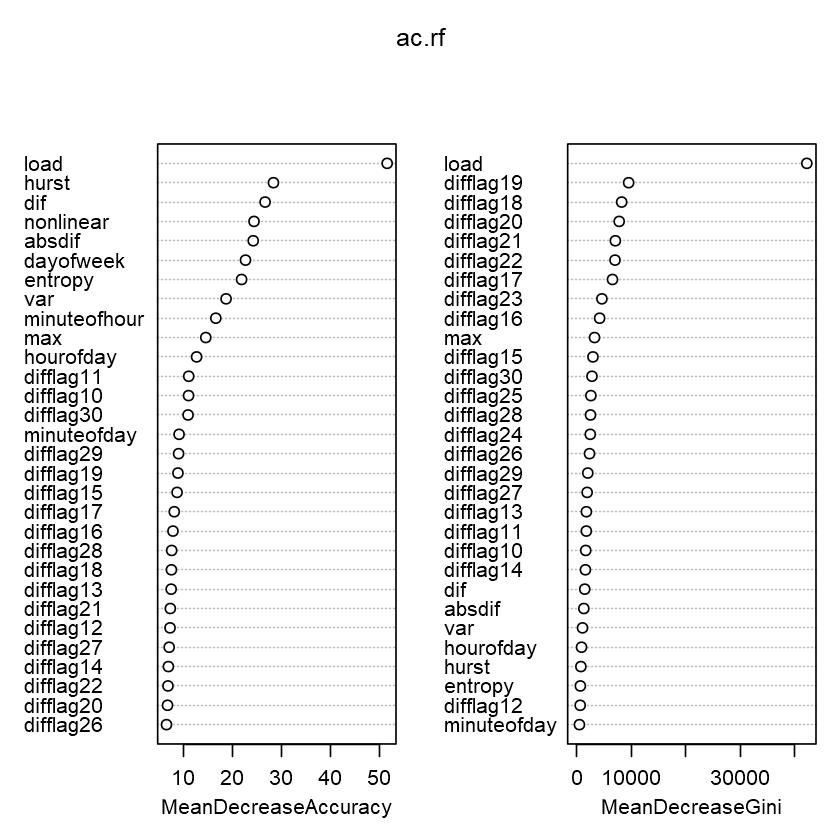

In [96]:
varImpPlot(ac.rf)

For `ac`, both Mean Decrease Accuracy and Mean Decrease Gini agree that load is the most important variable. This makes sense because in a typical household, air conditioner consumes a significant amount of electricity. Mean Decrease Accuracy also chooses `hurst`, `dif` and `nonlinear` as some of other top important variable, but by a much lesser extent as compared to load. 

`Hurst` measures the long-term memory of a time series. As the high values of `load` tends to coincides with activation of the air conditioner, it can be said that the time series has a good long-term memory, so it makes sense that `Hurst` is also considered an important variable. On the other hand, for Mean Decrease Gini, we see that right below `load`, all of the other top important variables are `difflag` variables like `difflag19` and `difflag18`, albeit to a much lesser extent as compared to `load`. This is understandable because people usually turn on the air conditioner for a certain period of time before turning it off. In this case, the model concludes that the ‘best’ window of time that the air conditioner is turned on is around 18 to 19 minutes.


### Inference for `ev`

In [97]:
importance(ev.rf)

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
load,18.179828,15.043813,20.236897,362.068420
hourofday,13.384050,10.965548,13.974695,64.740377
dayofweek,15.685817,16.692976,19.797992,55.202505
dif,6.271083,6.641143,7.238750,14.383649
absdif,11.868492,7.700399,13.063570,18.009279
max,13.634557,15.972486,17.662452,228.151243
var,10.075798,12.903866,12.967500,55.361866
entropy,16.023257,16.284147,21.057799,46.602267
nonlinear,11.834779,10.515930,14.023847,17.122006
hurst,21.458130,19.247536,25.858452,57.461888


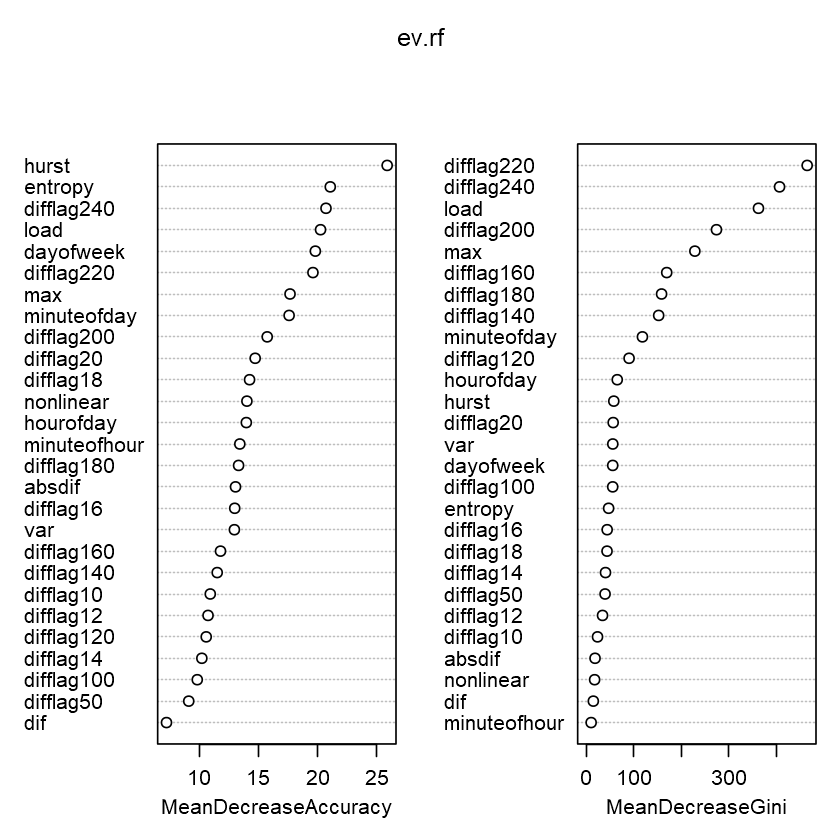

In [98]:
varImpPlot(ev.rf)

For `ev`, both Mean Decrease Accuracy and Mean Decrease Gini suggest that `load` and `difflag240` are among the top important variables. Mean Decrease Accuracy has `hurst` and `entropy` as the top 2 most important variables. In EDA portion in the notebook file, we also find out that `hurst` and `entropy` have a weak negative linear correlation, of about -0.676. This makes because increase in `hurst` means a greater long-term memory of a time series, which is consistent with a decrease in `entropy`, which means a higher signal-to-noise ratio, hence makes it easier to forecast. Nonetheless, since we place more emphasis on Mean Decrease Gini, difflag variables like `difflag220`, `difflag240` and `difflag200` are very important variables. These are high values of activation window, which makes a lot sense because for electric vehicle charger, people tend to leave it turned on to fully charge the electric vehicle, which can take several hours, which in turn is consistent with the values of `difflag` variables here.

### Inference for `oven`

In [99]:
importance(oven.rf)

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
load,47.670706,48.40035,58.09805,1447.09533
hourofday,15.143898,24.20546,22.87186,79.61989
dayofweek,30.181813,30.44239,36.16005,105.77600
dif,20.331773,17.99592,21.71528,280.18082
absdif,24.475485,28.00779,32.90089,591.37262
max,23.454200,30.49698,33.88870,372.69505
var,21.803289,43.55266,36.63012,380.44332
entropy,22.776601,30.79414,32.83617,364.55497
nonlinear,22.099086,28.79406,33.27662,86.24724
hurst,28.536876,40.20320,42.07616,415.04361


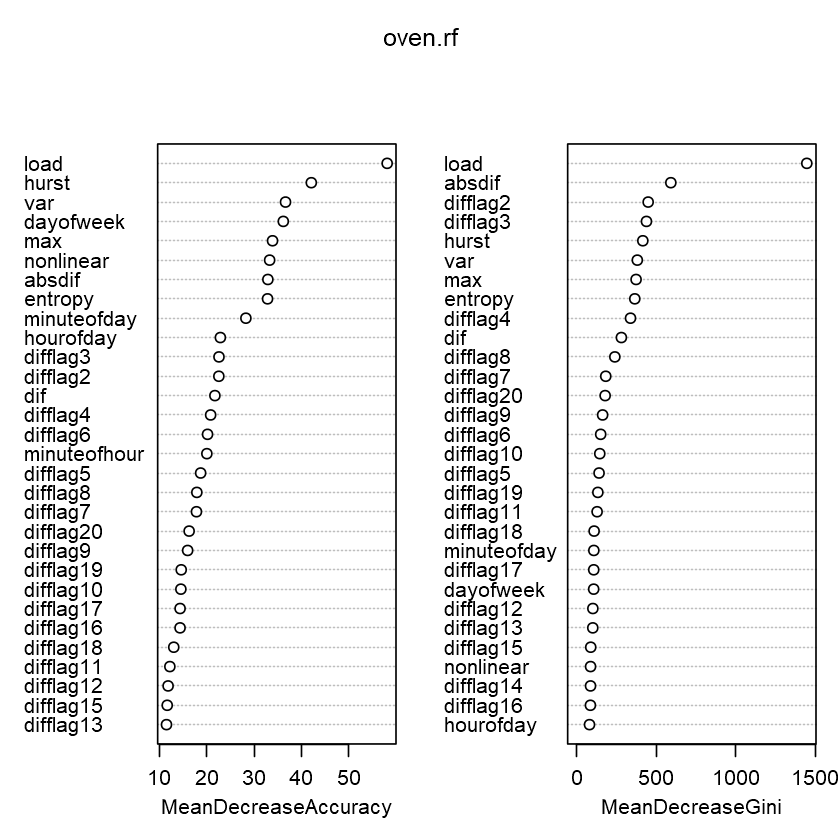

In [100]:
varImpPlot(oven.rf)

For `oven`, both Mean Decrease Accuracy and Mean Decrease Gini agree that load is the most important variable. `hurst` also presents in the top 5 in both categories. Interestingly, Mean Decrease Accuracy includes no `difflag` variables as the top important variable, but Mean Decrease Gini has `difflag2` and `difflag3` among the top important variables. However, this time, this is particularly strange because it usually takes the oven 10 to 15 minutes to preheat, so the result this time is not what we would expect.

### Inference for `wash`

In [101]:
importance(wash.rf)

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
load,64.26553,54.623087,67.47933,613.0421
hourofday,50.70727,66.352794,66.23754,539.3345
dayofweek,61.92011,72.500932,74.08642,419.6039
dif,32.20310,11.601202,31.53850,339.8214
absdif,50.52511,33.587815,56.21887,453.3860
max,49.16284,57.721656,64.34657,511.1273
var,57.45718,56.744320,75.44458,430.7069
entropy,46.88857,43.346857,59.13113,301.0003
nonlinear,48.38354,52.674618,58.68572,336.4721
hurst,52.69139,51.416742,64.79451,354.7830


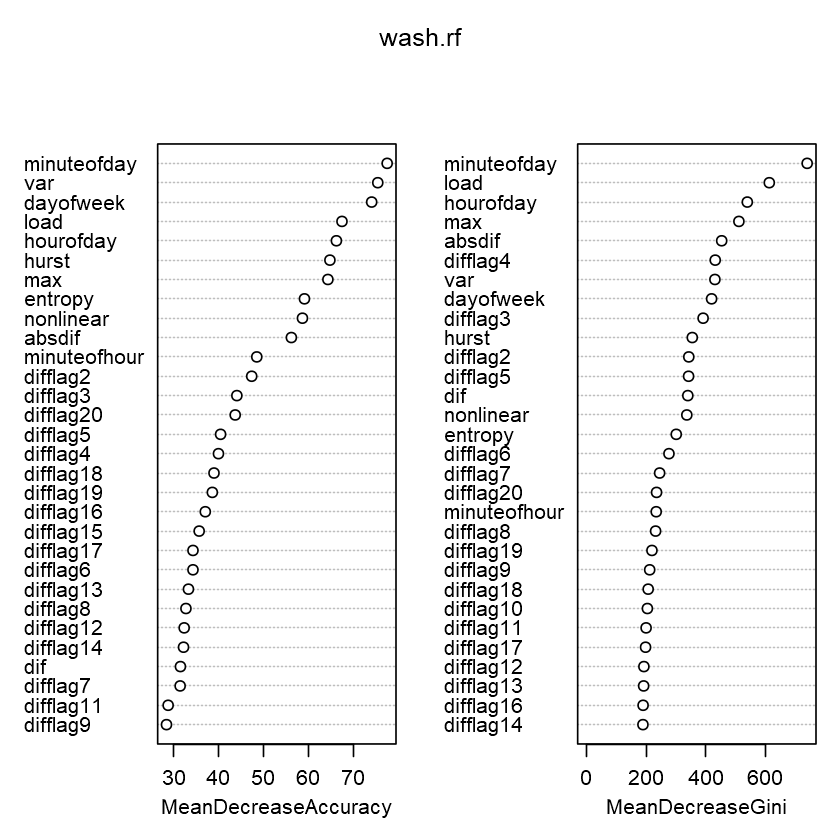

In [102]:
varImpPlot(wash.rf)

For `wash`, both Mean Decrease Accuracy and Mean Decrease Gini have `minuteofday` as their picks for the most important variable. This means that people might tend to use cloth washer in some very specific minutes within each day. This also makes sense because this is a daily/routine task, so people usually turn the cloth washer on during some specific period of time. In addition, `load` and `hourofday` are also among the top important variables.

### Inference for `dryer`

In [103]:
importance(dryer.rf)

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
load,61.30113,61.52322,73.53668,1416.2477
hourofday,58.27255,57.04283,61.44115,1684.2867
dayofweek,83.40437,79.57956,86.41626,795.5270
dif,19.62046,10.29229,22.11484,221.0705
absdif,30.16201,25.02092,30.60648,499.7620
max,56.08642,67.85497,69.60606,1049.7687
var,57.24805,43.33377,55.16484,666.3950
entropy,43.94080,45.09829,50.68433,359.4509
nonlinear,41.31805,45.98191,45.69643,410.6446
hurst,50.50494,48.35646,54.97957,467.2245


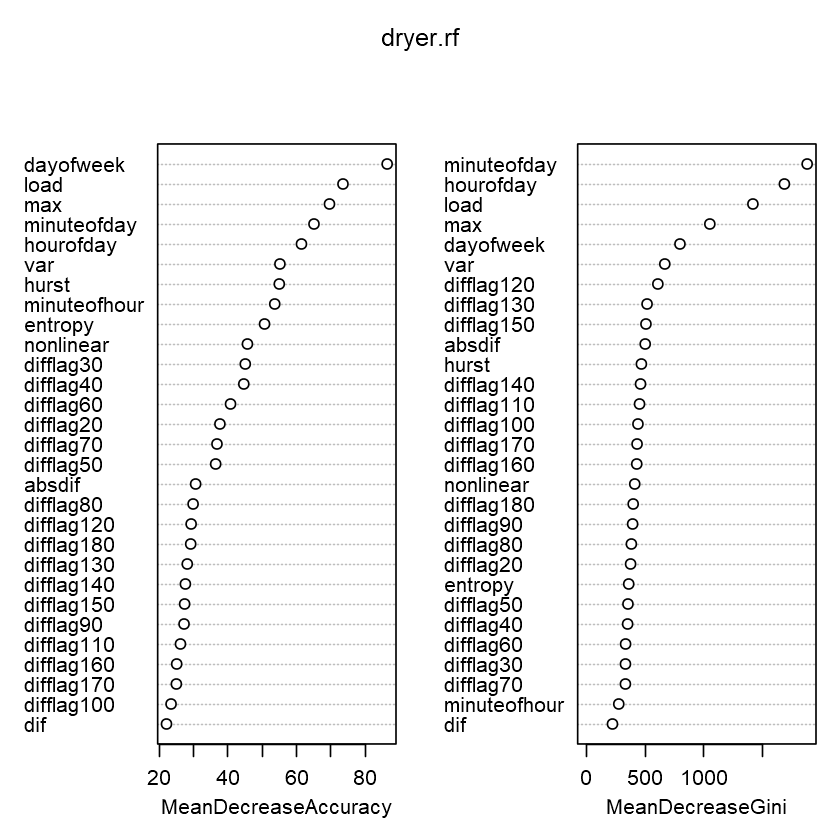

In [104]:
varImpPlot(dryer.rf)

For `dryer`, both Mean Decrease Accuracy and Mean Decrease Gini have the same choices for top 5 most important variables, but in different orders. These 5 variables are `dayofweek`, `load`, `minuteofday`, `max` and `hourofday`. Interestingly, there are no `difflag` variables at all.

### Conclusion

For this project, the biggest challenge and takeaway is how to best deal with **extreme class imbalance issue in a time-series data**. Various existing literatures have discussed at length on how to handle class imbalance issue, but mostly in the context of non-time-series data. I have to come up with my own way of attempting to alleviate the class imbalance issue before we fit the model on the data. 

Our method of **undersampling** manages to **preserve the structure of the time-series to a certain extent**, while making the **proportion of classes much more balanced**. Admittedly, by undersampling in this way, there are 2 main downsides. 
- The first downside is that we considerably shrink the training size, thus losing out a lot of information that might be crucial for the model. As mentioned previously, while we try to make the models more sensitive towards detecting positive cases, we over-do it with this undersampling method, resulting in too many positive cases predicted, which in turn leads to many False Positive. 
- The second downside is that these smaller subsets/segments that we extracted are not necessarily connected. For some appliances, it might take days for people to use them again. Therefore, although data within each subset is sequential, the subsets themselves might not be sequential with respect to one another, as we can see from the hand-drawn image. In this way, we were not able to completely preserve the sequential structure of the time-series data. 

Even though we try to resolve the issue on the data side so that the model development stage can be better, we feel like we still fall short. This is evident by very mediocre f1 scores for target variables that have this class imbalance issue. For future work, we think oversampling might be a better option as compared to undersampling, if the resource and time constraints are not too big of an issue.

All in all, this project provides an excellent learning opportunity to tackle an issue that I have not had a chance to deal with before. Instead of trying to come up with the best algorithms or tuning of hyperparameters, we feel that this project shows us that the model is only as good as the data that it is trained on. Therefore, we need to devise several effective strategies to clean, pre-process and deal with any issues arose from the data side, before we can fit it to the models.